### 1. Functions and variables for collecting predictions

In [ ]:
import os
import numpy as np
import cv2
from detection import detect_face_for_testing
from feature_extraction import predict_spoof
from anti_spoof import load_antispoof_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

DATASET_PATH_REAL = "LCC_eval_pics/real"
DATASET_PATH_ATTACK = "LCC_eval_pics/spoof"
SAVE_PATH = 'results_FAS/'
N_REAL = 314
N_SPOOFED = 700
N_RUNS = 10 # Number of test runs
SPOOF_THRESHOLDS = np.concatenate(([0], np.arange(0.90, 1.01, 0.01)))

antispoof_sess, antispoof_input = load_antispoof_model()

def get_image_paths(dataset_path, n_images):
    # Get n random image paths from the dataset
    image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
    sampled_image_paths = np.random.choice(image_paths, n_images, replace=False)

    return sampled_image_paths

def get_predictions(dataset_path, correct_pred, thresholds, n_pred):
    n_undetected = 0
    y_pred_li = [[] for _ in range(len(thresholds))] # Initialize a list of predictions for each threshold
    
    image_paths = get_image_paths(dataset_path, n_pred)

    for image_path in image_paths: 
        image_array = cv2.imread(image_path)

        if image_array is None:
            print(f"Error reading image: {image_path}")
            continue
        
        face_data, image_rgb = detect_face_for_testing(image_array)

        if face_data is not None:

            for i, threshold in enumerate(thresholds):
                # Check if the image is spoofed based on the face data
                pred = predict_spoof(face_data, image_rgb, antispoof_sess, antispoof_input, threshold)

                if pred != correct_pred:
                    #print(f'Incorrect prediction at: {image_path}')
                    pass

                y_pred_li[i].append(pred) # Append the prediction to the list for the current threshold
        else:
            n_undetected += 1
            #print(f"No face detected in image: {image_path}")
        
    print(f"Number of undetected images: {n_undetected}")
    return y_pred_li, n_undetected

def run_test(path_real, path_attack, thresholds, n_real, n_spoofed, test_n):
    # Collect one list of predictions for non-spoofed images for every threshold
    y_pred_real_li, n_undetected_real = get_predictions(path_real, True, thresholds, n_real)
    y_true_real = np.full(len(y_pred_real_li[0]), True)
    print(f"Number of real images: {len(y_pred_real_li[0])}")

    # Collect one list of predictions for spoofed images for every threshold
    y_pred_attack_li, n_undetected_attack = get_predictions(path_attack, False, thresholds, n_spoofed)
    y_true_attack = np.full(len(y_pred_attack_li[0]), False)
    print(f"Number of spoofed images: {len(y_pred_attack_li[0])}")

    y_pred_li = [y_pred_real + y_pred_attack for (y_pred_real, y_pred_attack) in zip(y_pred_real_li, y_pred_attack_li)]
    y_true = np.concatenate((y_true_real, y_true_attack))

    rows = []

    for y_pred, threshold in zip(y_pred_li, thresholds):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        rows.append({
            'Test Number': test_n,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Undetected Real Images': n_undetected_real,
            'Undetected Spoofed Images': n_undetected_attack
        })

        print(f"Threshold: {threshold:.2f}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    df = pd.DataFrame(rows)

    return y_pred_li, y_true, df



### 2. Collecting predictions on images for each threshold, then plotting ROC curves and confusion matrices

Test number: 1
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 195
Number of spoofed images: 505
Threshold: 0.00
Accuracy: 0.3375, Precision: 0.3128, Recall: 1.0000, F1-score: 0.4765

Threshold: 0.90
Accuracy: 0.7497, Precision: 0.5698, Recall: 0.6927, F1-score: 0.6253

Threshold: 0.91
Accuracy: 0.7580, Precision: 0.5837, Recall: 0.6881, F1-score: 0.6316

Threshold: 0.92
Accuracy: 0.7607, Precision: 0.5918, Recall: 0.6651, F1-score: 0.6263

Threshold: 0.93
Accuracy: 0.7621, Precision: 0.5966, Recall: 0.6514, F1-score: 0.6228

Threshold: 0.94
Accuracy: 0.7552, Precision: 0.5911, Recall: 0.6101, F1-score: 0.6005

Threshold: 0.95
Accuracy: 0.7538, Precision: 0.5909, Recall: 0.5963, F1-score: 0.5936

Threshold: 0.96
Accuracy: 0.7580, Precision: 0.6019, Recall: 0.5826, F1-score: 0.5921

Threshold: 0.97
Accuracy: 0.7649, Precision: 0.6263, Recall: 0.5459, F1-score: 0.5833

Threshold: 0.98
Accuracy: 0.7676, Precision: 0.6471, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


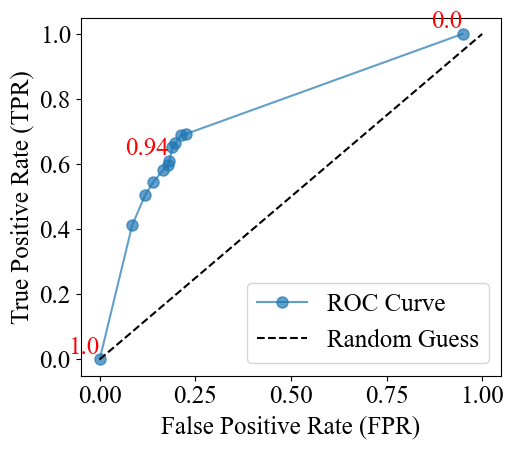

Confusion matrix for threshold 0.00:


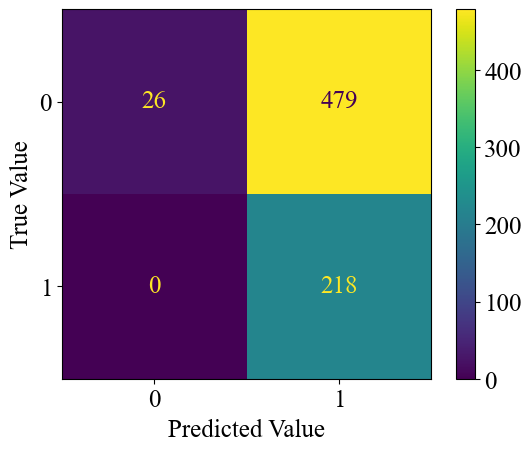

Confusion matrix for threshold 0.90:


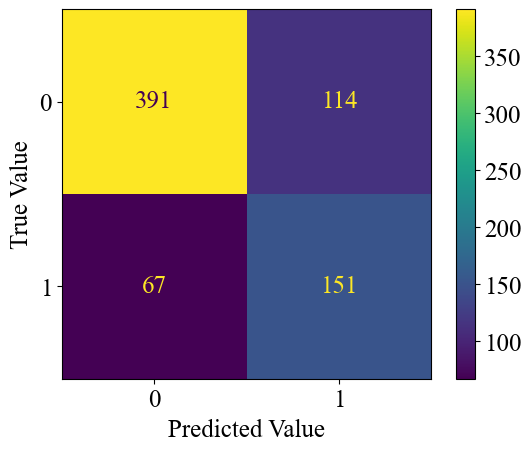

Confusion matrix for threshold 0.91:


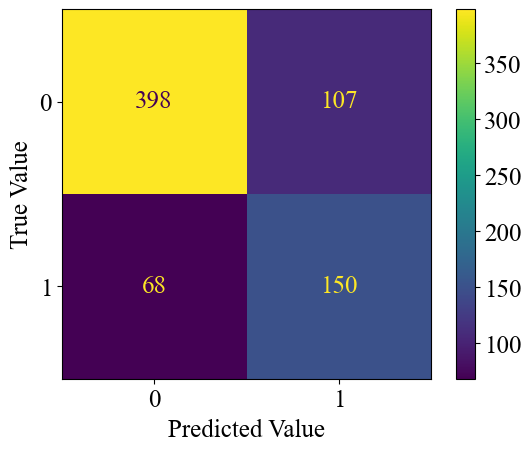

Confusion matrix for threshold 0.92:


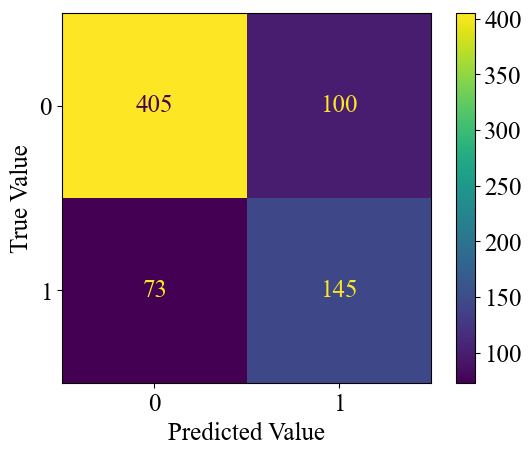

Confusion matrix for threshold 0.93:


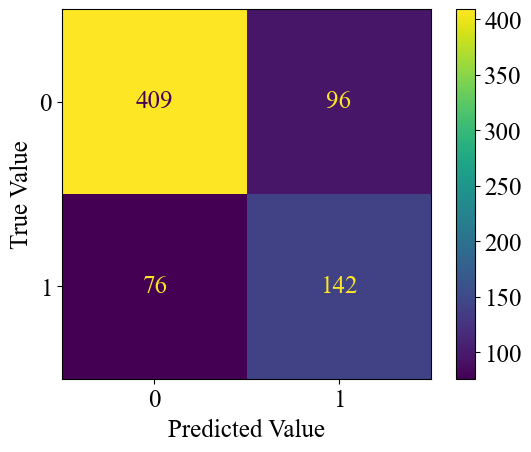

Confusion matrix for threshold 0.94:


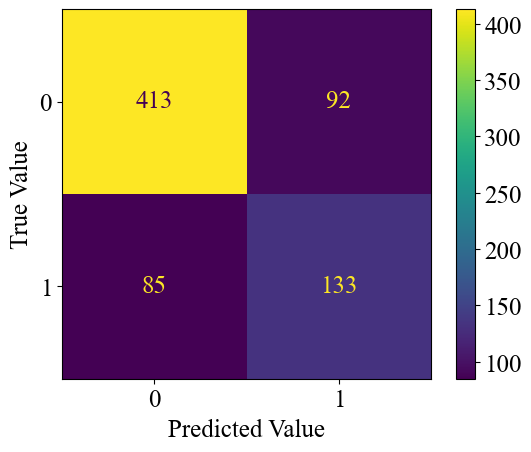

Confusion matrix for threshold 0.95:


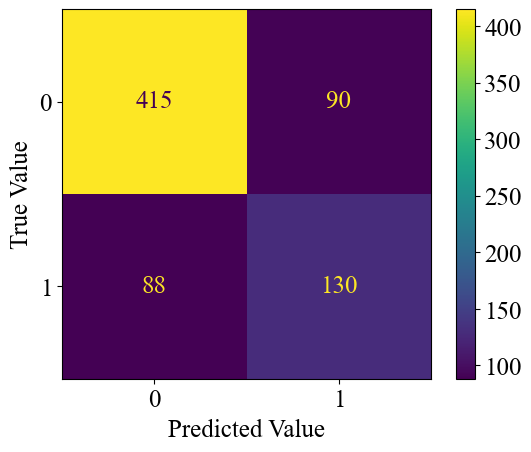

Confusion matrix for threshold 0.96:


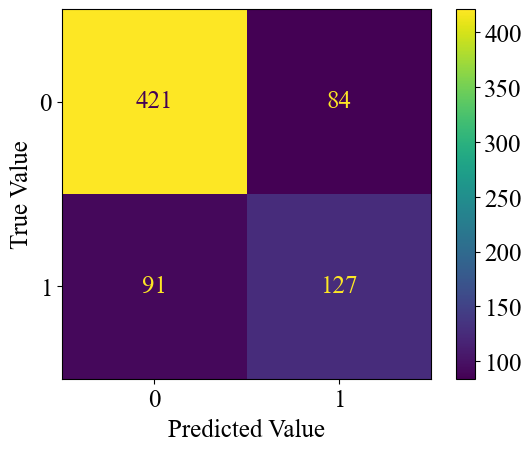

Confusion matrix for threshold 0.97:


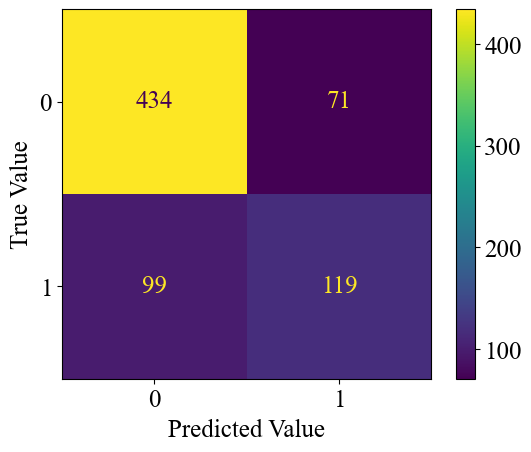

Confusion matrix for threshold 0.98:


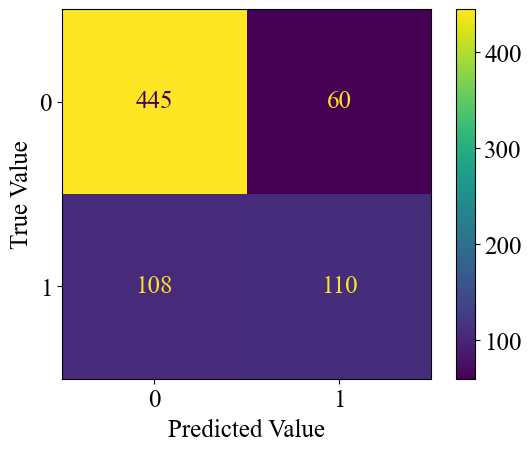

Confusion matrix for threshold 0.99:


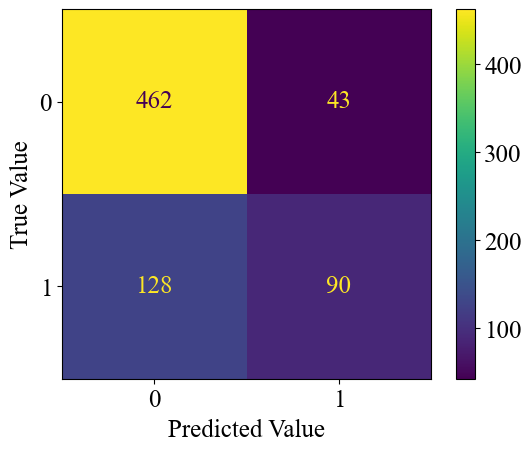

Confusion matrix for threshold 1.00:


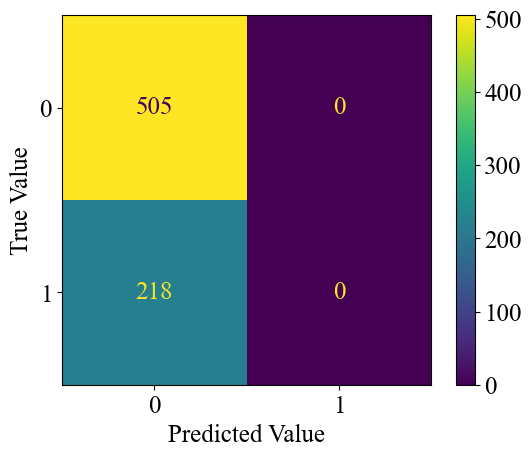

Test number: 2
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 199
Number of spoofed images: 501
Threshold: 0.00
Accuracy: 0.3352, Precision: 0.3132, Recall: 1.0000, F1-score: 0.4770

Threshold: 0.90
Accuracy: 0.7510, Precision: 0.5741, Recall: 0.6927, F1-score: 0.6279

Threshold: 0.91
Accuracy: 0.7552, Precision: 0.5814, Recall: 0.6881, F1-score: 0.6303

Threshold: 0.92
Accuracy: 0.7594, Precision: 0.5918, Recall: 0.6651, F1-score: 0.6263

Threshold: 0.93
Accuracy: 0.7608, Precision: 0.5966, Recall: 0.6514, F1-score: 0.6228

Threshold: 0.94
Accuracy: 0.7510, Precision: 0.5859, Recall: 0.6101, F1-score: 0.5978

Threshold: 0.95
Accuracy: 0.7538, Precision: 0.5936, Recall: 0.5963, F1-score: 0.5950

Threshold: 0.96
Accuracy: 0.7580, Precision: 0.6048, Recall: 0.5826, F1-score: 0.5935

Threshold: 0.97
Accuracy: 0.7552, Precision: 0.6071, Recall: 0.5459, F1-score: 0.5749

Threshold: 0.98
Accuracy: 0.7580, Precision: 0.6250, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


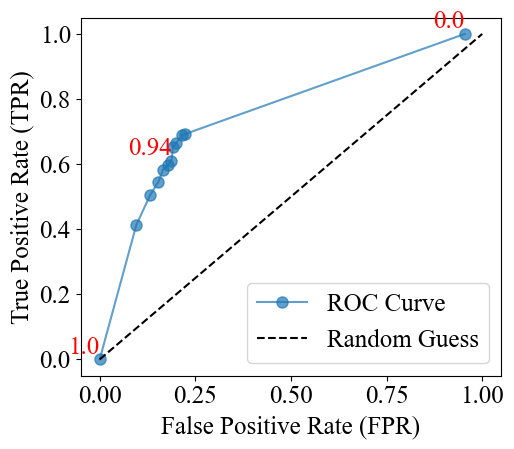

Confusion matrix for threshold 0.00:


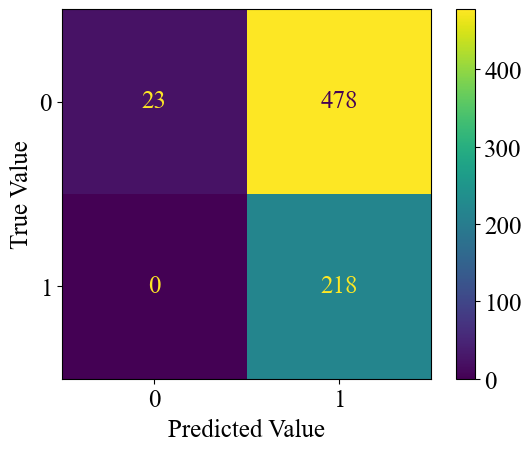

Confusion matrix for threshold 0.90:


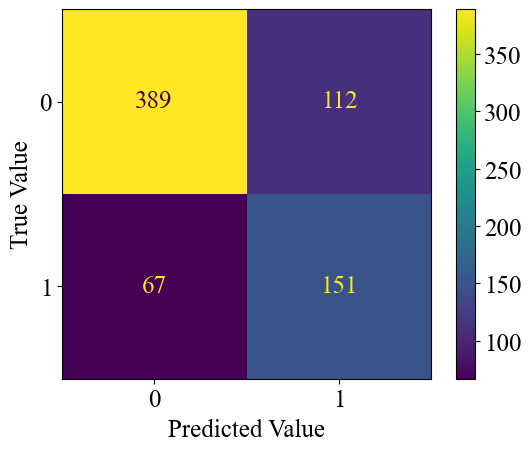

Confusion matrix for threshold 0.91:


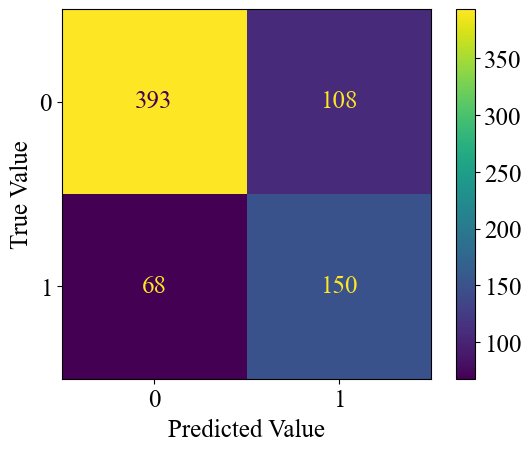

Confusion matrix for threshold 0.92:


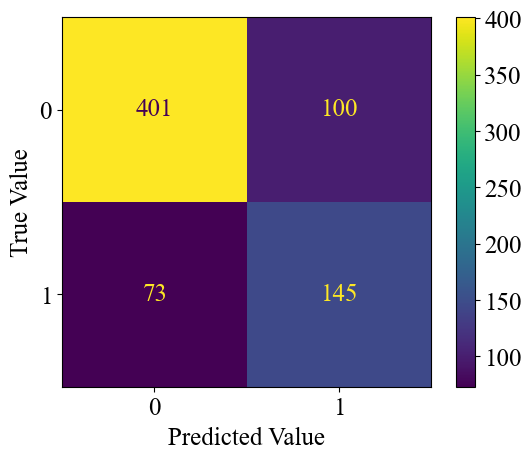

Confusion matrix for threshold 0.93:


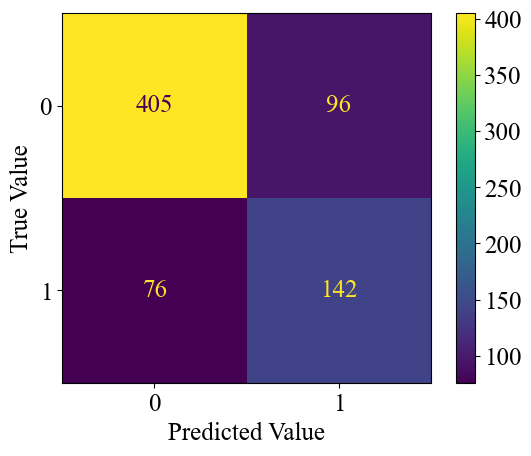

Confusion matrix for threshold 0.94:


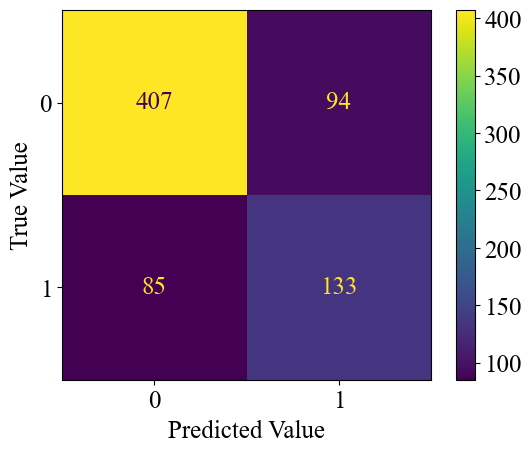

Confusion matrix for threshold 0.95:


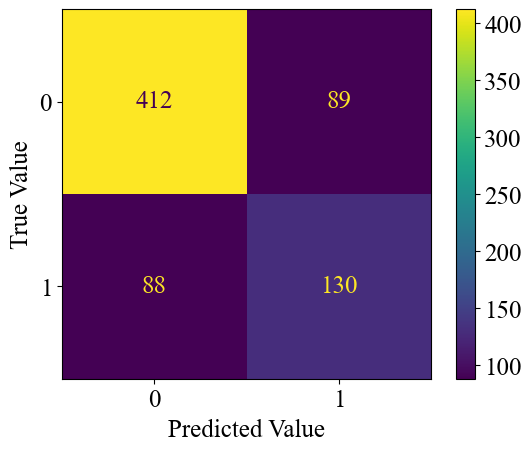

Confusion matrix for threshold 0.96:


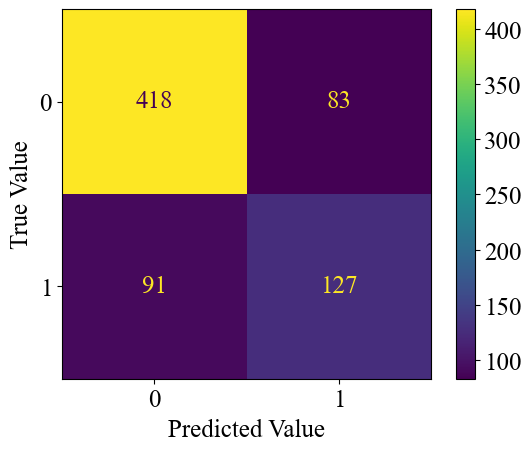

Confusion matrix for threshold 0.97:


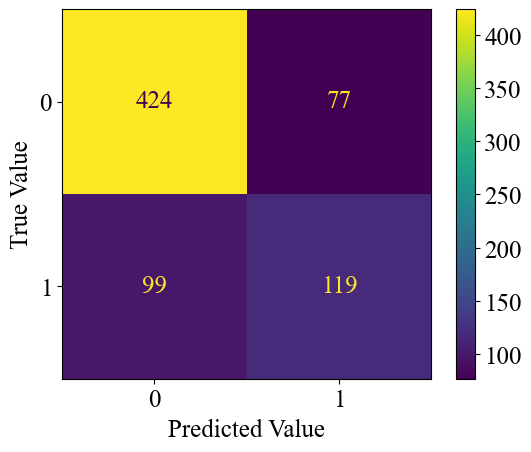

Confusion matrix for threshold 0.98:


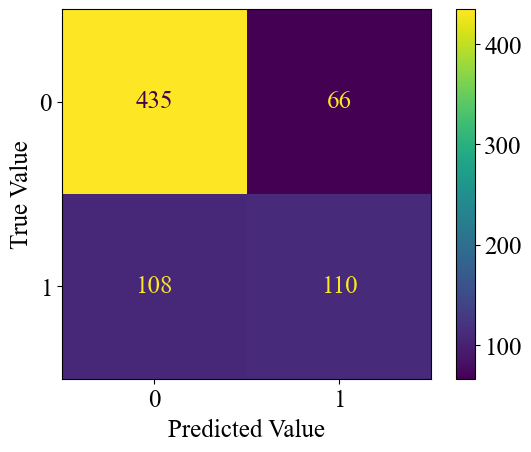

Confusion matrix for threshold 0.99:


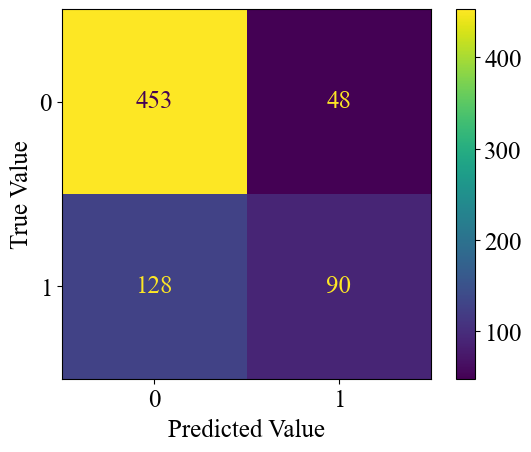

Confusion matrix for threshold 1.00:


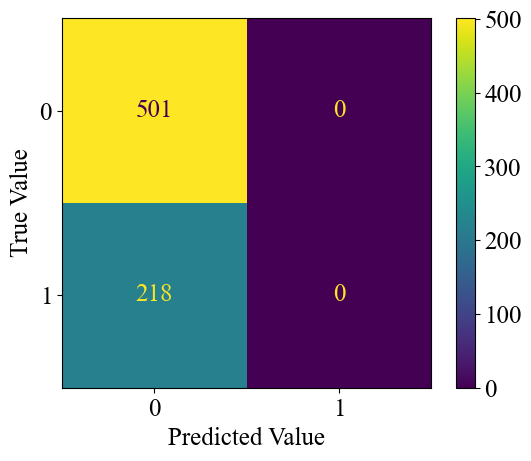

Test number: 3
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 208
Number of spoofed images: 492
Threshold: 0.00
Accuracy: 0.3507, Precision: 0.3211, Recall: 1.0000, F1-score: 0.4861

Threshold: 0.90
Accuracy: 0.7592, Precision: 0.5922, Recall: 0.6927, F1-score: 0.6385

Threshold: 0.91
Accuracy: 0.7620, Precision: 0.5976, Recall: 0.6881, F1-score: 0.6397

Threshold: 0.92
Accuracy: 0.7662, Precision: 0.6092, Recall: 0.6651, F1-score: 0.6360

Threshold: 0.93
Accuracy: 0.7690, Precision: 0.6174, Recall: 0.6514, F1-score: 0.6339

Threshold: 0.94
Accuracy: 0.7690, Precision: 0.6274, Recall: 0.6101, F1-score: 0.6186

Threshold: 0.95
Accuracy: 0.7718, Precision: 0.6373, Recall: 0.5963, F1-score: 0.6161

Threshold: 0.96
Accuracy: 0.7690, Precision: 0.6350, Recall: 0.5826, F1-score: 0.6077

Threshold: 0.97
Accuracy: 0.7648, Precision: 0.6364, Recall: 0.5459, F1-score: 0.5877

Threshold: 0.98
Accuracy: 0.7676, Precision: 0.6587, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


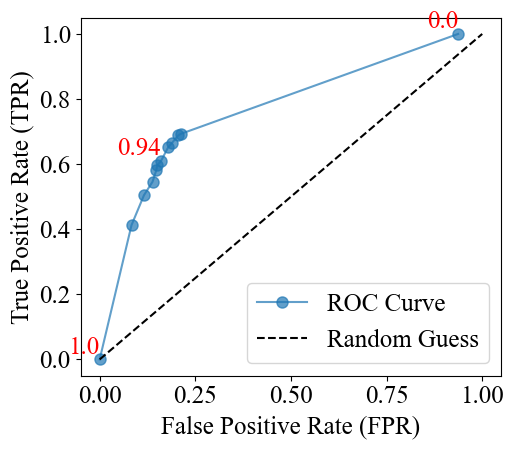

Confusion matrix for threshold 0.00:


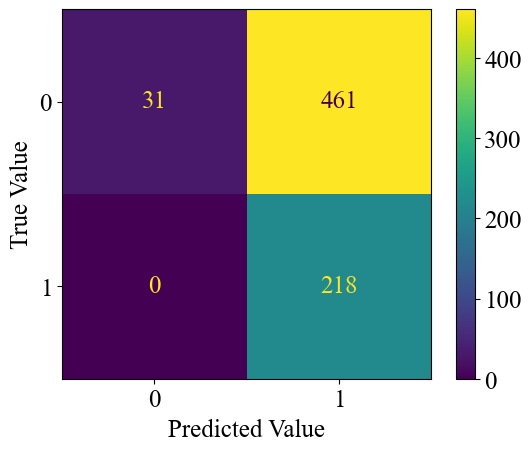

Confusion matrix for threshold 0.90:


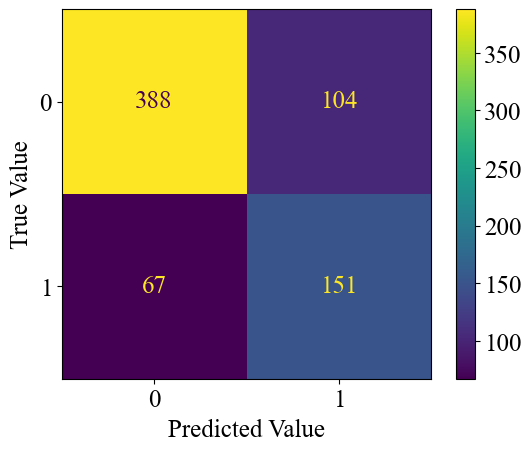

Confusion matrix for threshold 0.91:


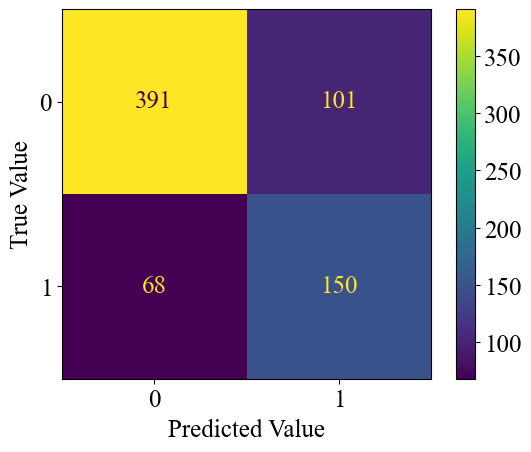

Confusion matrix for threshold 0.92:


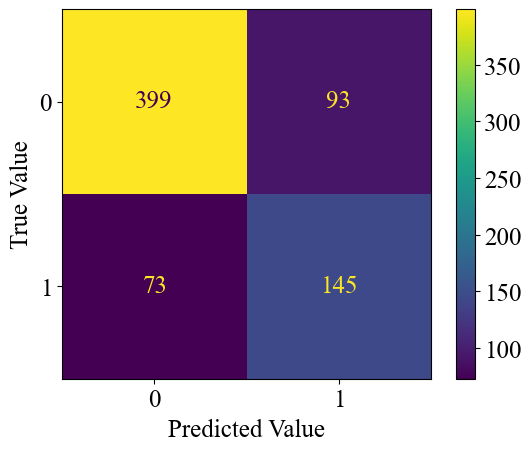

Confusion matrix for threshold 0.93:


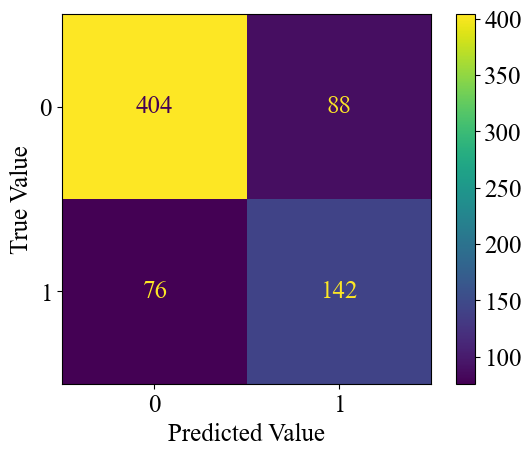

Confusion matrix for threshold 0.94:


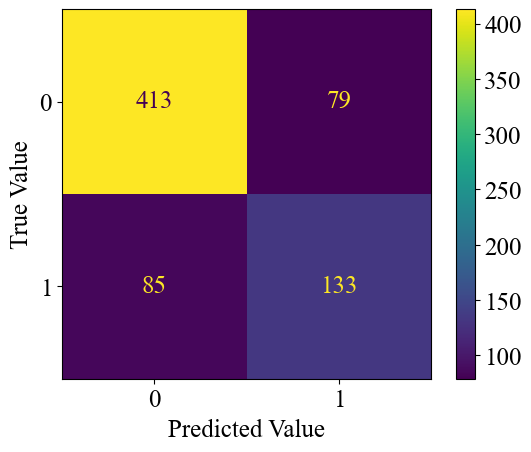

Confusion matrix for threshold 0.95:


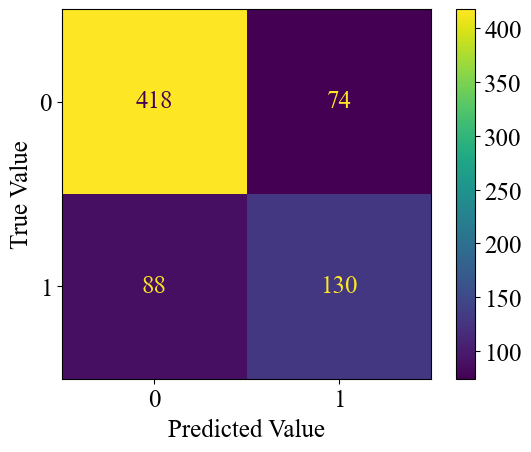

Confusion matrix for threshold 0.96:


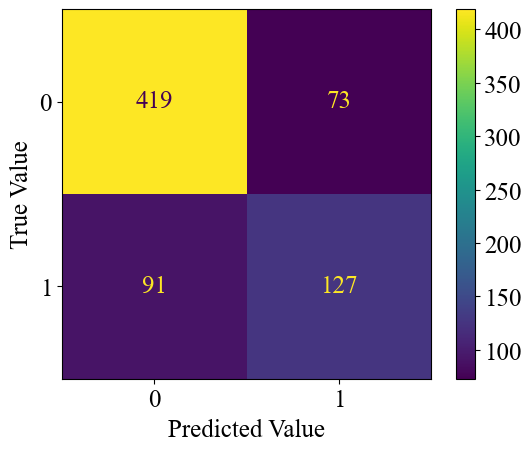

Confusion matrix for threshold 0.97:


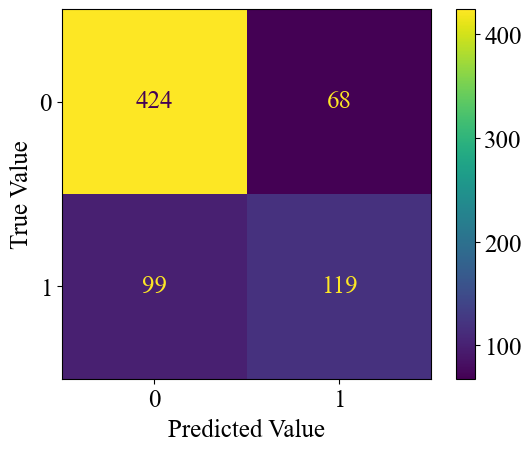

Confusion matrix for threshold 0.98:


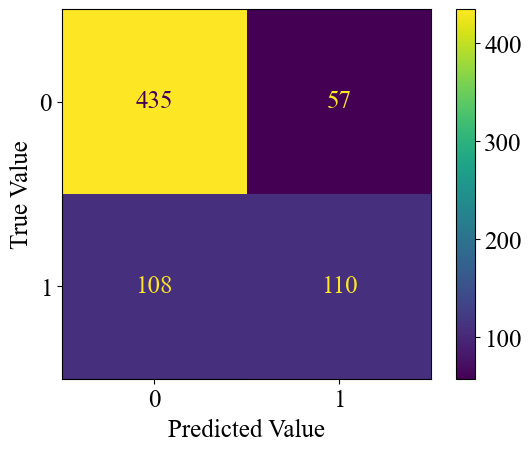

Confusion matrix for threshold 0.99:


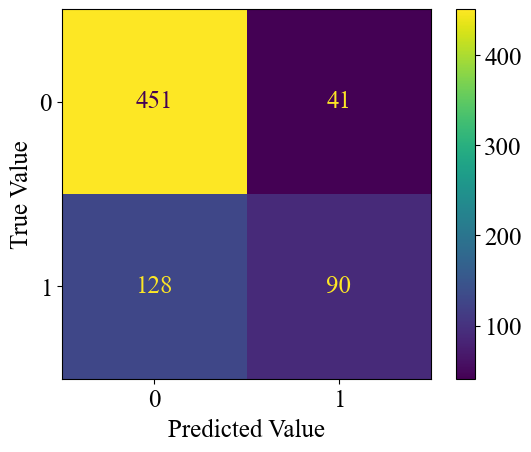

Confusion matrix for threshold 1.00:


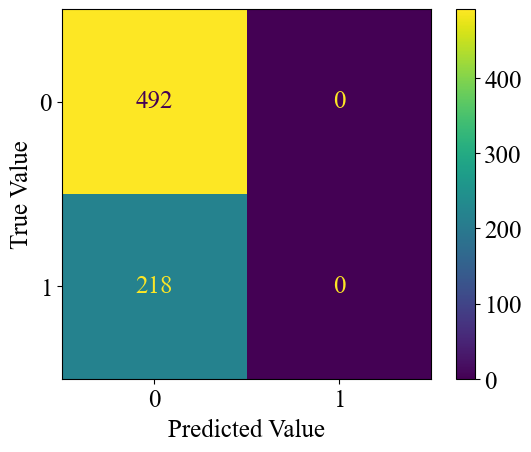

Test number: 4
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 198
Number of spoofed images: 502
Threshold: 0.00
Accuracy: 0.3417, Precision: 0.3150, Recall: 1.0000, F1-score: 0.4791

Threshold: 0.90
Accuracy: 0.7639, Precision: 0.5945, Recall: 0.6927, F1-score: 0.6398

Threshold: 0.91
Accuracy: 0.7722, Precision: 0.6098, Recall: 0.6881, F1-score: 0.6466

Threshold: 0.92
Accuracy: 0.7833, Precision: 0.6360, Recall: 0.6651, F1-score: 0.6502

Threshold: 0.93
Accuracy: 0.7847, Precision: 0.6425, Recall: 0.6514, F1-score: 0.6469

Threshold: 0.94
Accuracy: 0.7792, Precision: 0.6425, Recall: 0.6101, F1-score: 0.6259

Threshold: 0.95
Accuracy: 0.7778, Precision: 0.6436, Recall: 0.5963, F1-score: 0.6190

Threshold: 0.96
Accuracy: 0.7819, Precision: 0.6580, Recall: 0.5826, F1-score: 0.6180

Threshold: 0.97
Accuracy: 0.7806, Precision: 0.6685, Recall: 0.5459, F1-score: 0.6010

Threshold: 0.98
Accuracy: 0.7778, Precision: 0.6790, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


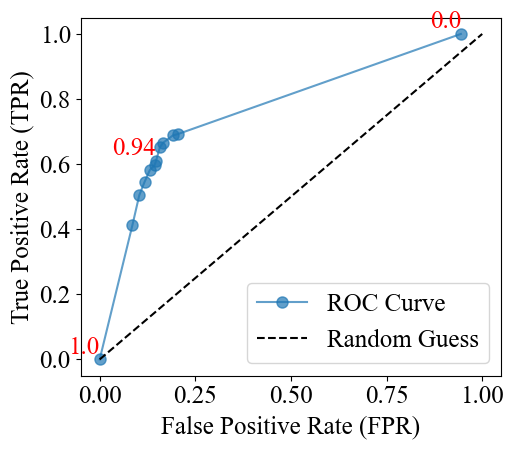

Confusion matrix for threshold 0.00:


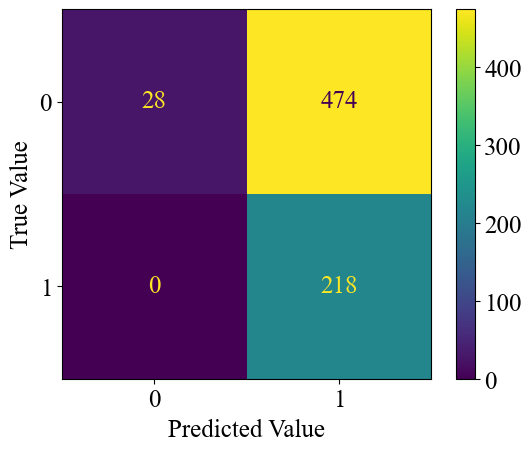

Confusion matrix for threshold 0.90:


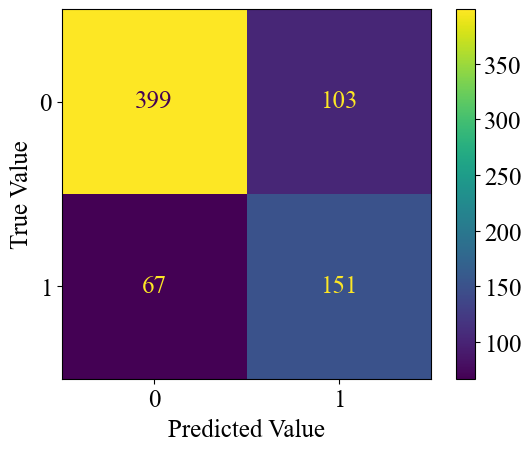

Confusion matrix for threshold 0.91:


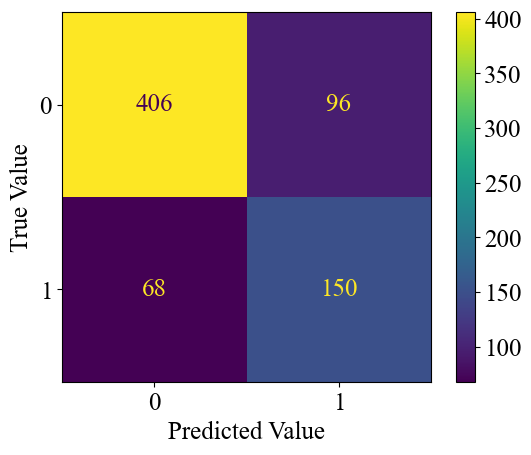

Confusion matrix for threshold 0.92:


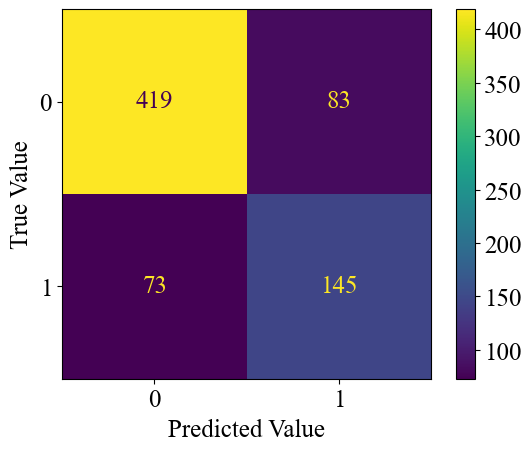

Confusion matrix for threshold 0.93:


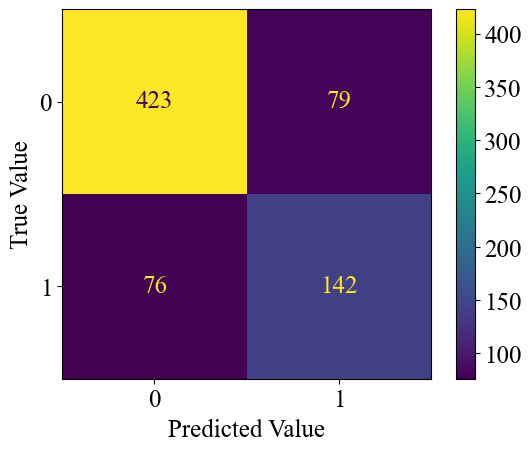

Confusion matrix for threshold 0.94:


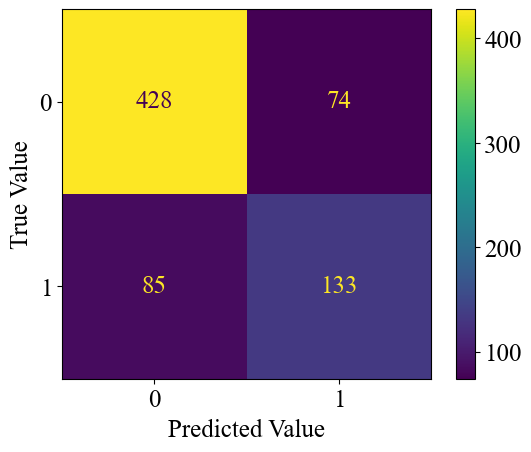

Confusion matrix for threshold 0.95:


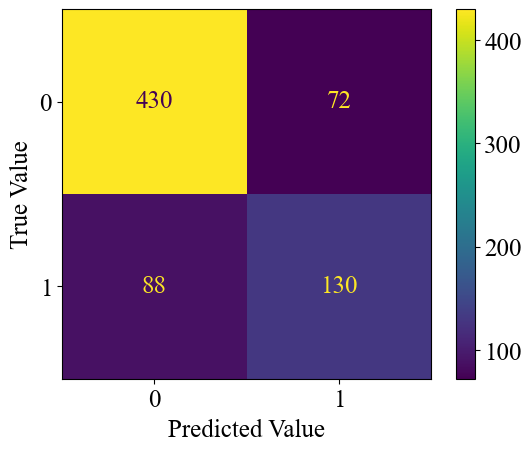

Confusion matrix for threshold 0.96:


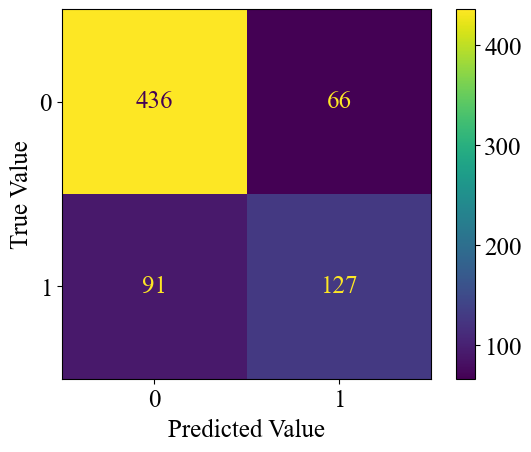

Confusion matrix for threshold 0.97:


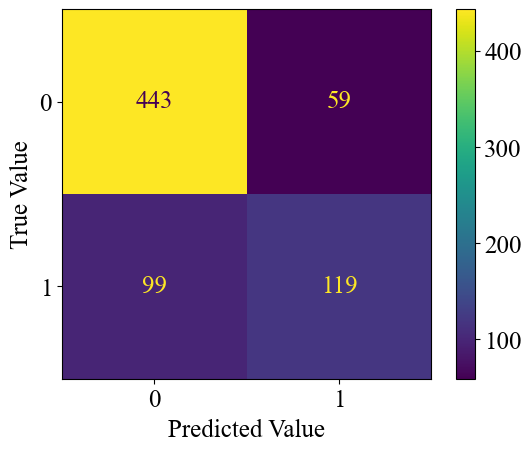

Confusion matrix for threshold 0.98:


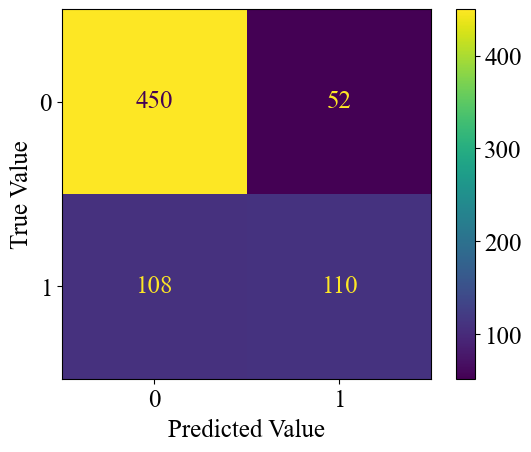

Confusion matrix for threshold 0.99:


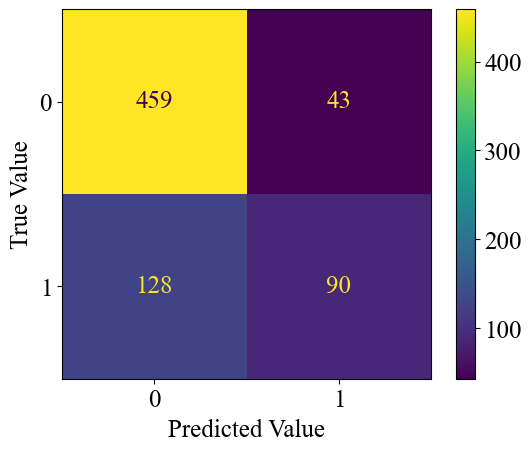

Confusion matrix for threshold 1.00:


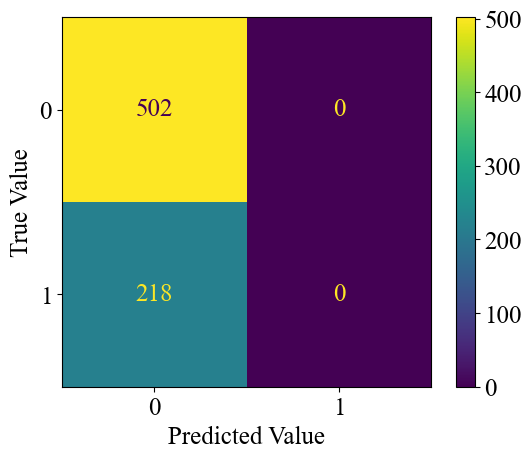

Test number: 5
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 221
Number of spoofed images: 479
Threshold: 0.00
Accuracy: 0.3429, Precision: 0.3225, Recall: 1.0000, F1-score: 0.4877

Threshold: 0.90
Accuracy: 0.7575, Precision: 0.5968, Recall: 0.6927, F1-score: 0.6412

Threshold: 0.91
Accuracy: 0.7575, Precision: 0.5976, Recall: 0.6881, F1-score: 0.6397

Threshold: 0.92
Accuracy: 0.7575, Precision: 0.6017, Recall: 0.6651, F1-score: 0.6318

Threshold: 0.93
Accuracy: 0.7590, Precision: 0.6068, Recall: 0.6514, F1-score: 0.6283

Threshold: 0.94
Accuracy: 0.7532, Precision: 0.6045, Recall: 0.6101, F1-score: 0.6073

Threshold: 0.95
Accuracy: 0.7604, Precision: 0.6220, Recall: 0.5963, F1-score: 0.6089

Threshold: 0.96
Accuracy: 0.7704, Precision: 0.6480, Recall: 0.5826, F1-score: 0.6135

Threshold: 0.97
Accuracy: 0.7733, Precision: 0.6685, Recall: 0.5459, F1-score: 0.6010

Threshold: 0.98
Accuracy: 0.7762, Precision: 0.6962, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


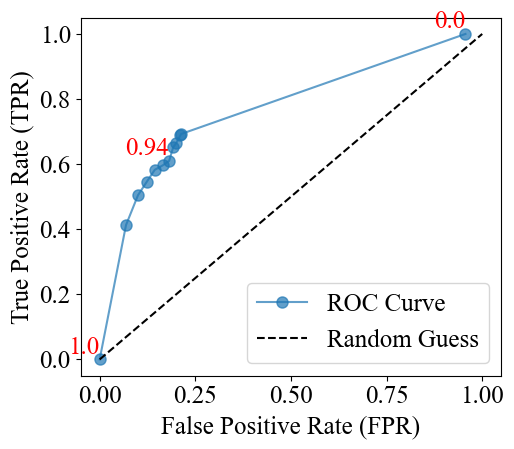

Confusion matrix for threshold 0.00:


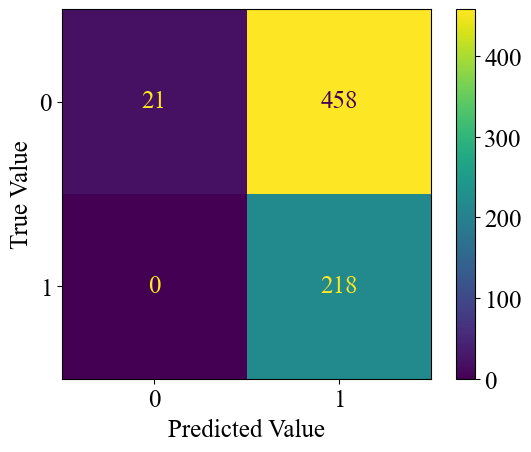

Confusion matrix for threshold 0.90:


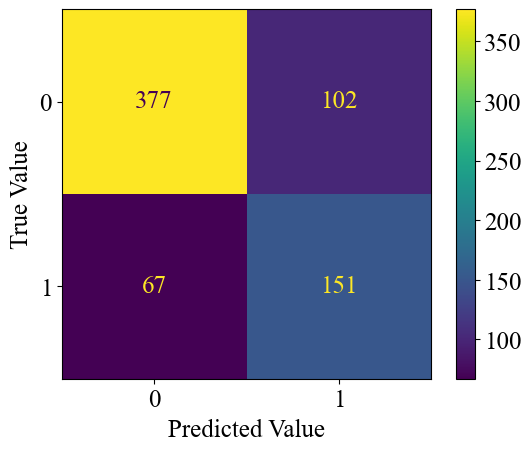

Confusion matrix for threshold 0.91:


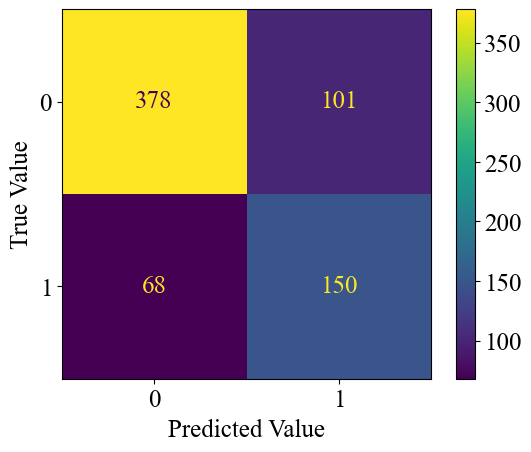

Confusion matrix for threshold 0.92:


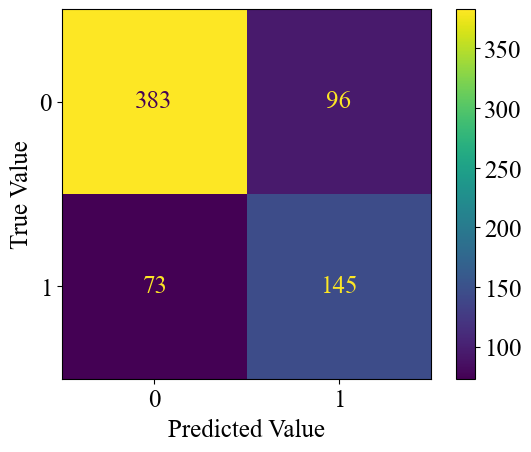

Confusion matrix for threshold 0.93:


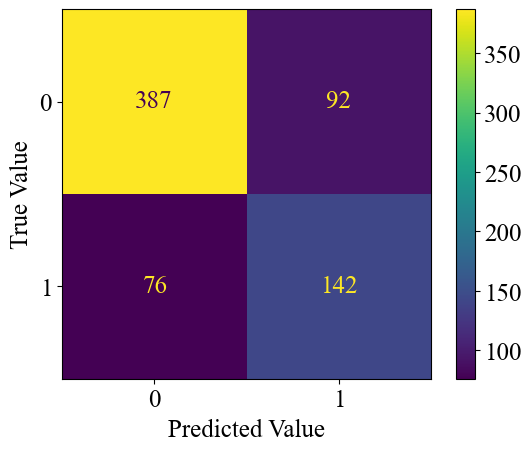

Confusion matrix for threshold 0.94:


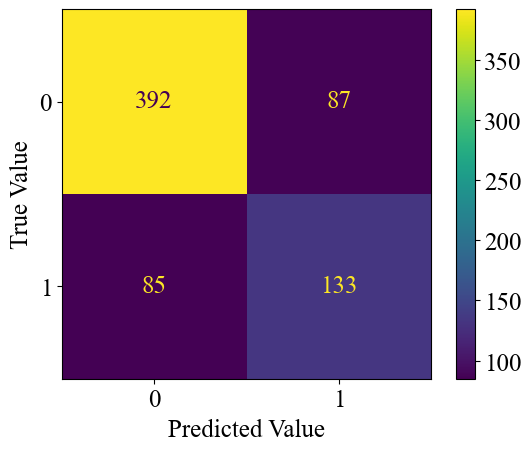

Confusion matrix for threshold 0.95:


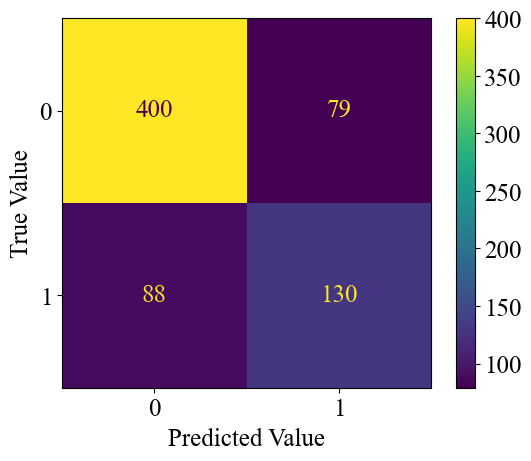

Confusion matrix for threshold 0.96:


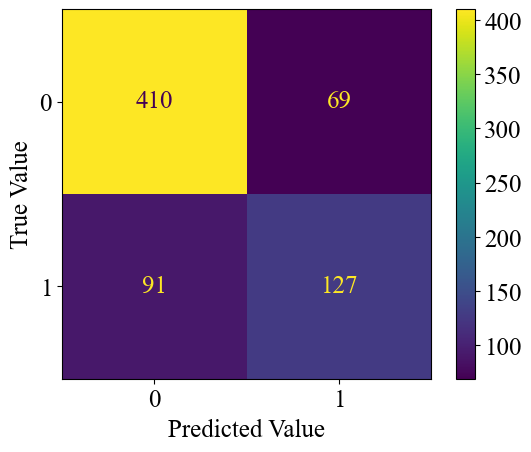

Confusion matrix for threshold 0.97:


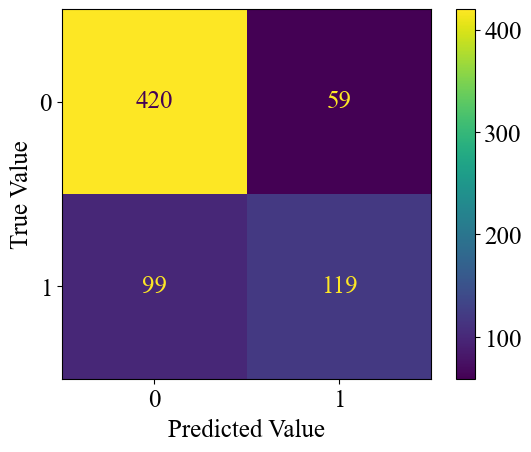

Confusion matrix for threshold 0.98:


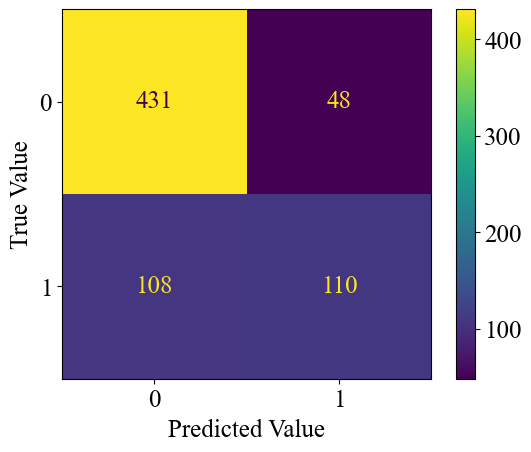

Confusion matrix for threshold 0.99:


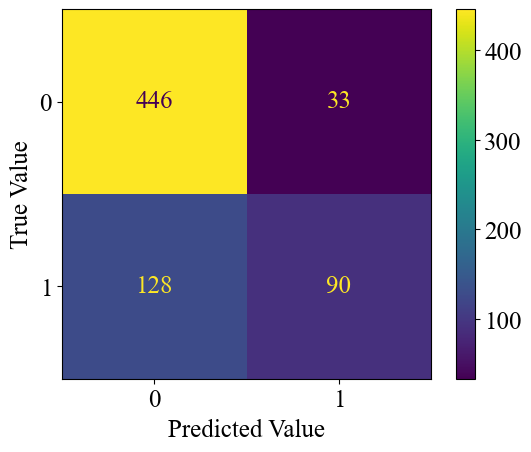

Confusion matrix for threshold 1.00:


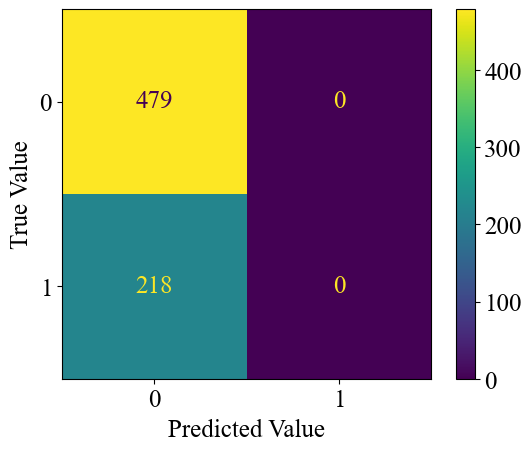

Test number: 6
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 177
Number of spoofed images: 523
Threshold: 0.00
Accuracy: 0.3360, Precision: 0.3070, Recall: 1.0000, F1-score: 0.4698

Threshold: 0.90
Accuracy: 0.7638, Precision: 0.5830, Recall: 0.6927, F1-score: 0.6331

Threshold: 0.91
Accuracy: 0.7692, Precision: 0.5929, Recall: 0.6881, F1-score: 0.6369

Threshold: 0.92
Accuracy: 0.7719, Precision: 0.6017, Recall: 0.6651, F1-score: 0.6318

Threshold: 0.93
Accuracy: 0.7692, Precision: 0.5992, Recall: 0.6514, F1-score: 0.6242

Threshold: 0.94
Accuracy: 0.7706, Precision: 0.6101, Recall: 0.6101, F1-score: 0.6101

Threshold: 0.95
Accuracy: 0.7719, Precision: 0.6161, Recall: 0.5963, F1-score: 0.6061

Threshold: 0.96
Accuracy: 0.7773, Precision: 0.6318, Recall: 0.5826, F1-score: 0.6062

Threshold: 0.97
Accuracy: 0.7800, Precision: 0.6503, Recall: 0.5459, F1-score: 0.5935

Threshold: 0.98
Accuracy: 0.7895, Precision: 0.6962, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


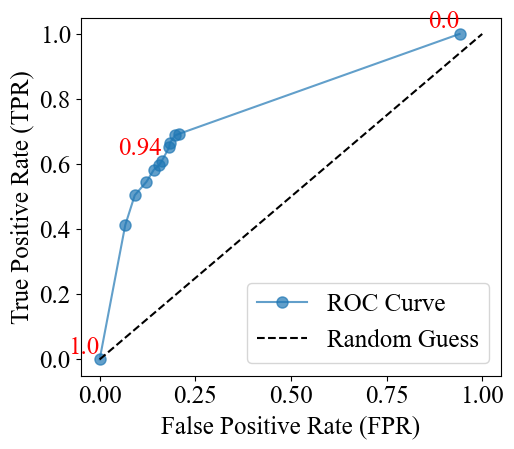

Confusion matrix for threshold 0.00:


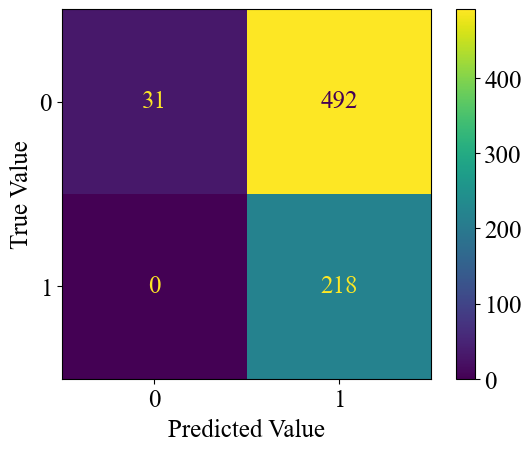

Confusion matrix for threshold 0.90:


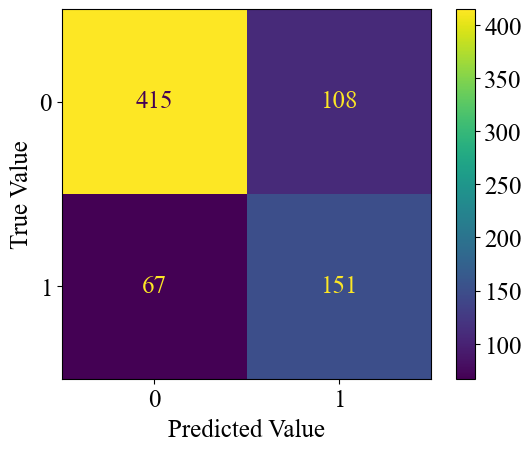

Confusion matrix for threshold 0.91:


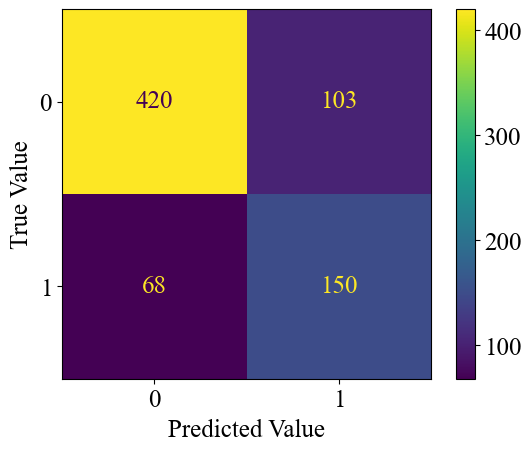

Confusion matrix for threshold 0.92:


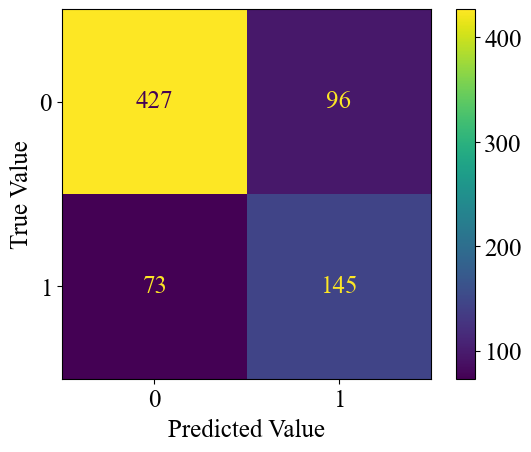

Confusion matrix for threshold 0.93:


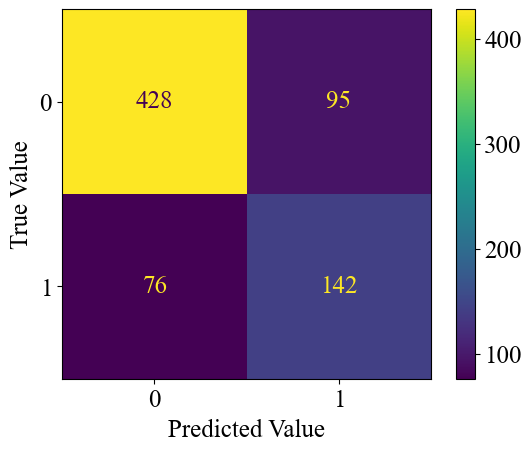

Confusion matrix for threshold 0.94:


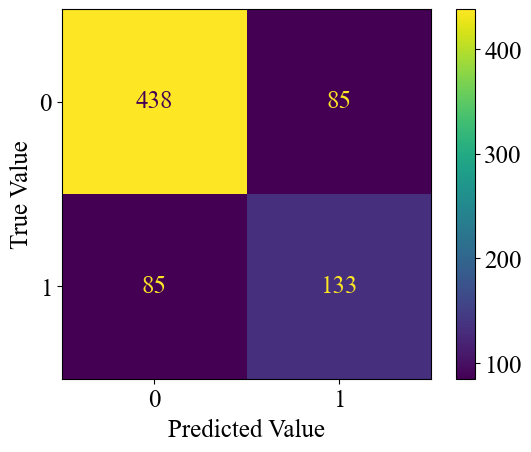

Confusion matrix for threshold 0.95:


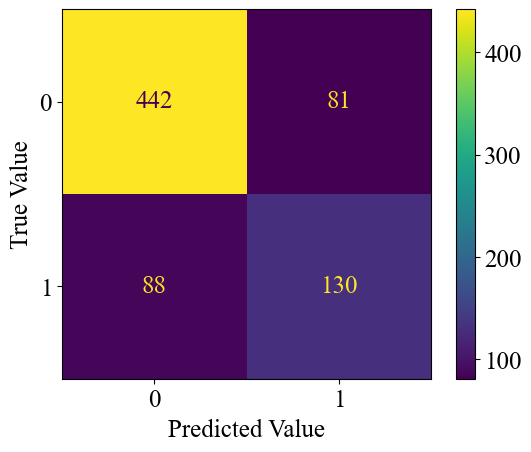

Confusion matrix for threshold 0.96:


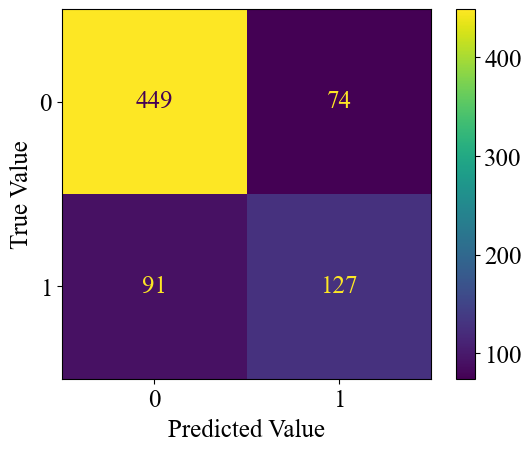

Confusion matrix for threshold 0.97:


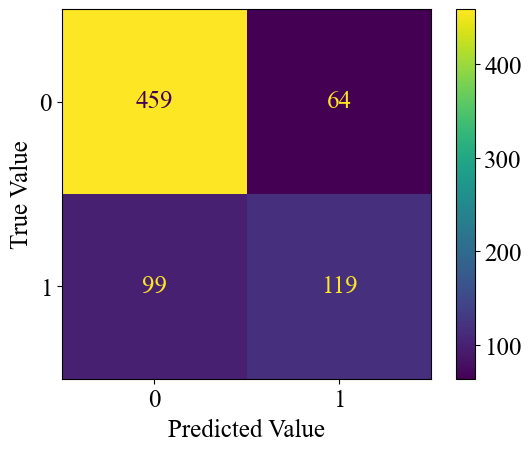

Confusion matrix for threshold 0.98:


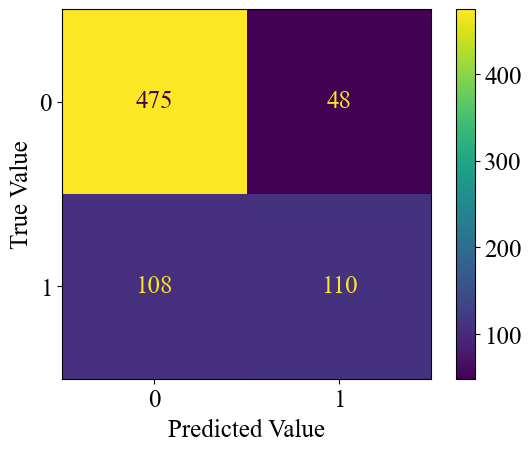

Confusion matrix for threshold 0.99:


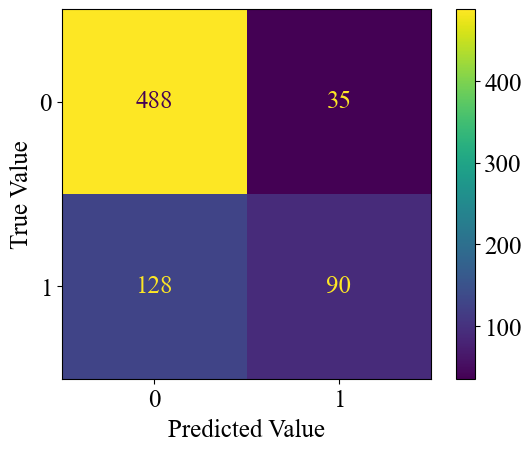

Confusion matrix for threshold 1.00:


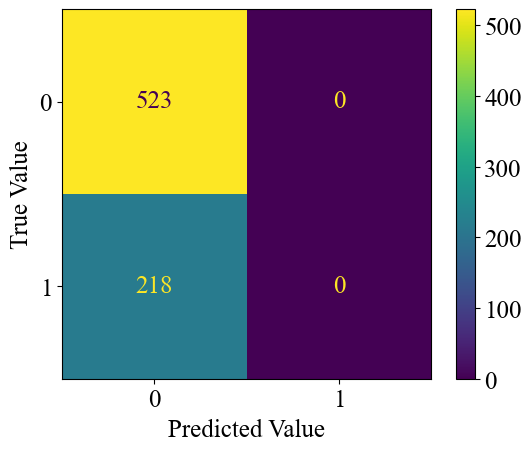

Test number: 7
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 191
Number of spoofed images: 509
Threshold: 0.00
Accuracy: 0.3301, Precision: 0.3092, Recall: 1.0000, F1-score: 0.4724

Threshold: 0.90
Accuracy: 0.7634, Precision: 0.5898, Recall: 0.6927, F1-score: 0.6371

Threshold: 0.91
Accuracy: 0.7634, Precision: 0.5906, Recall: 0.6881, F1-score: 0.6356

Threshold: 0.92
Accuracy: 0.7703, Precision: 0.6067, Recall: 0.6651, F1-score: 0.6346

Threshold: 0.93
Accuracy: 0.7717, Precision: 0.6121, Recall: 0.6514, F1-score: 0.6311

Threshold: 0.94
Accuracy: 0.7634, Precision: 0.6045, Recall: 0.6101, F1-score: 0.6073

Threshold: 0.95
Accuracy: 0.7675, Precision: 0.6161, Recall: 0.5963, F1-score: 0.6061

Threshold: 0.96
Accuracy: 0.7730, Precision: 0.6318, Recall: 0.5826, F1-score: 0.6062

Threshold: 0.97
Accuracy: 0.7744, Precision: 0.6467, Recall: 0.5459, F1-score: 0.5920

Threshold: 0.98
Accuracy: 0.7840, Precision: 0.6918, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


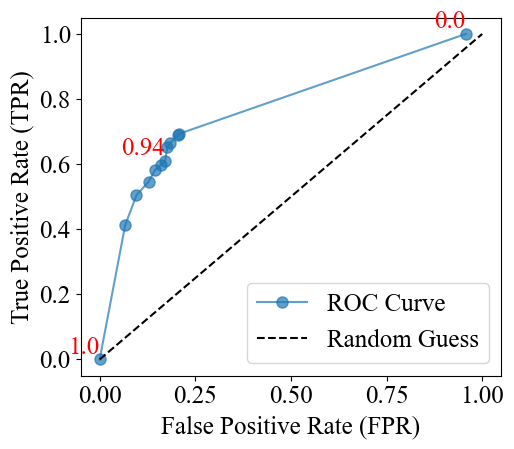

Confusion matrix for threshold 0.00:


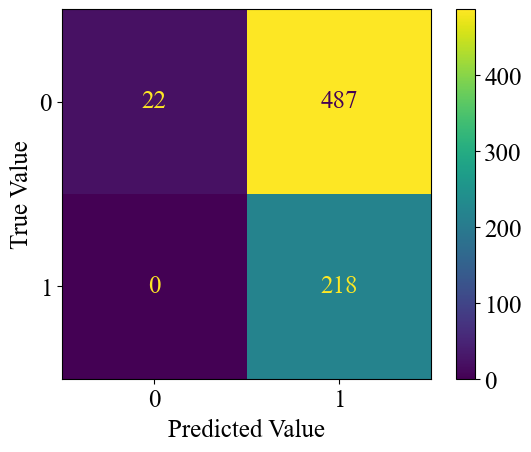

Confusion matrix for threshold 0.90:


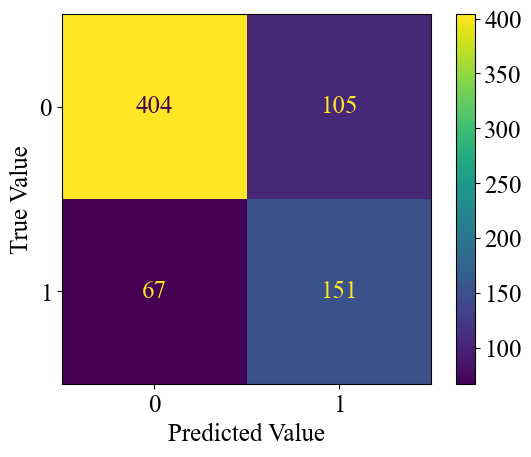

Confusion matrix for threshold 0.91:


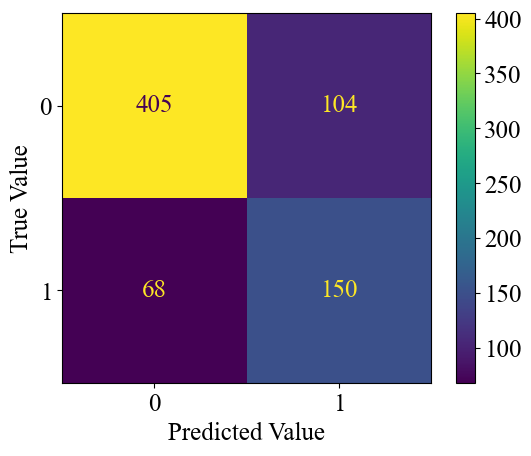

Confusion matrix for threshold 0.92:


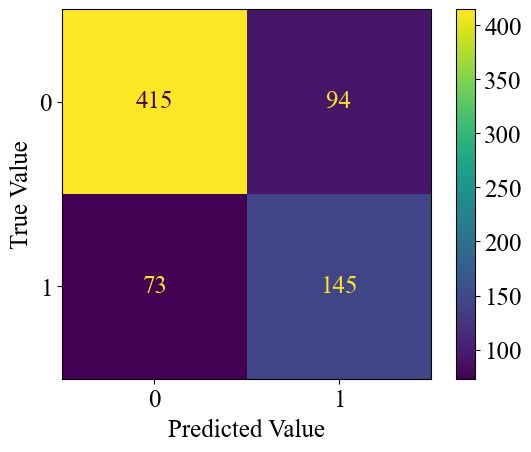

Confusion matrix for threshold 0.93:


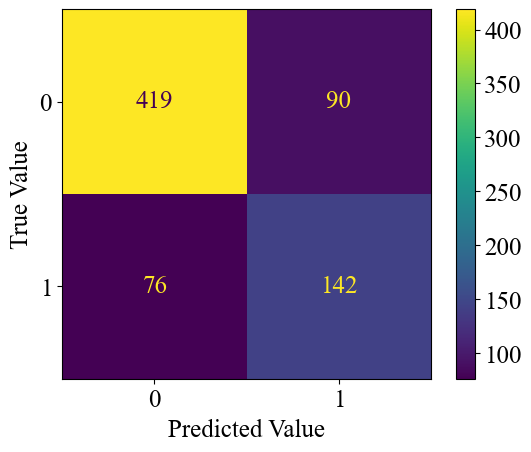

Confusion matrix for threshold 0.94:


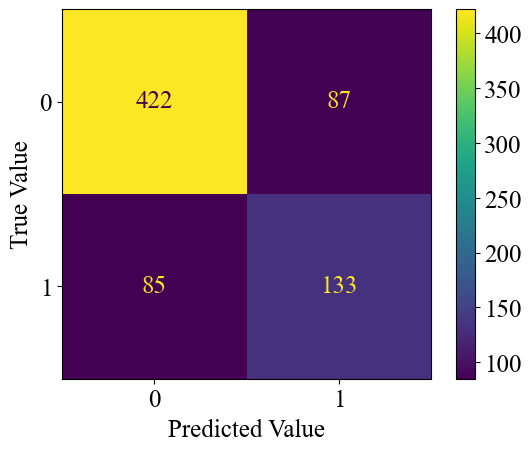

Confusion matrix for threshold 0.95:


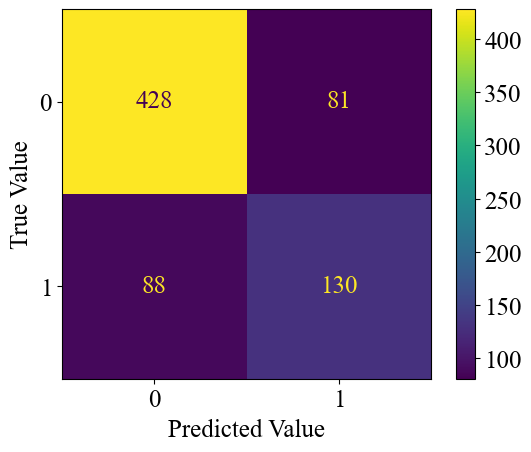

Confusion matrix for threshold 0.96:


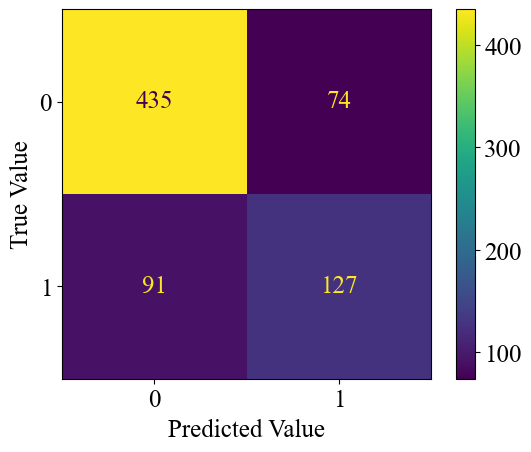

Confusion matrix for threshold 0.97:


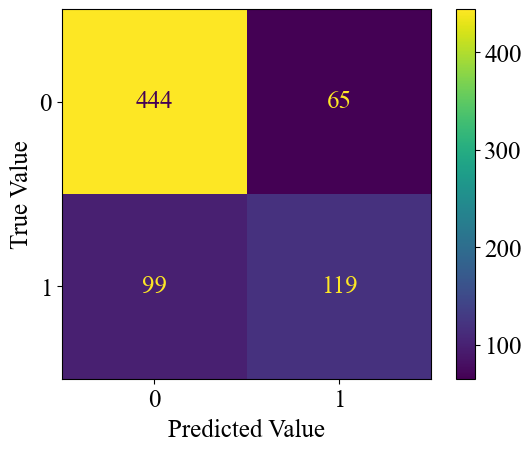

Confusion matrix for threshold 0.98:


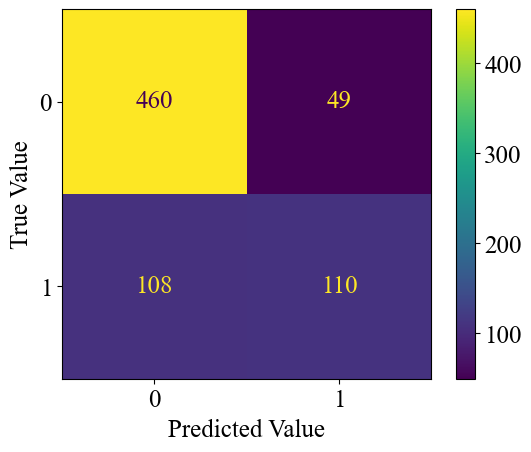

Confusion matrix for threshold 0.99:


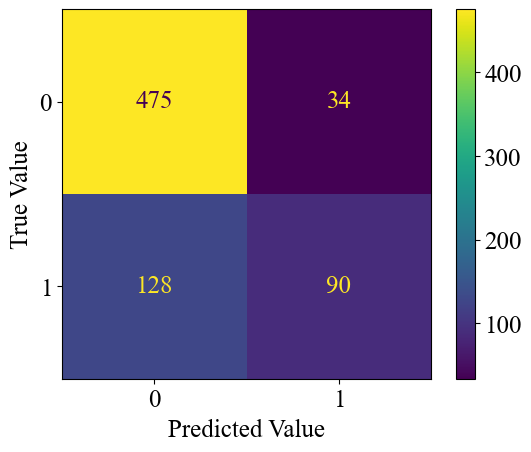

Confusion matrix for threshold 1.00:


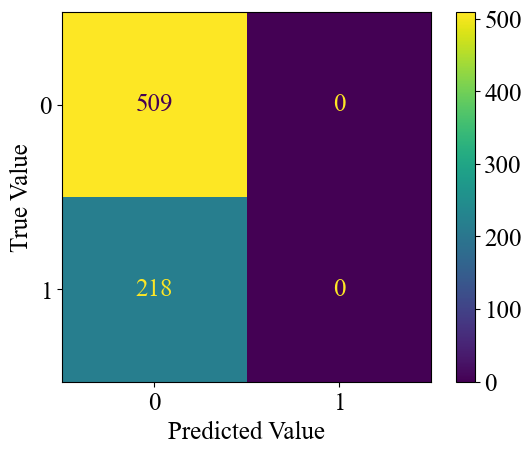

Test number: 8
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 186
Number of spoofed images: 514
Threshold: 0.00
Accuracy: 0.3443, Precision: 0.3123, Recall: 1.0000, F1-score: 0.4760

Threshold: 0.90
Accuracy: 0.7732, Precision: 0.6040, Recall: 0.6927, F1-score: 0.6453

Threshold: 0.91
Accuracy: 0.7773, Precision: 0.6122, Recall: 0.6881, F1-score: 0.6479

Threshold: 0.92
Accuracy: 0.7787, Precision: 0.6197, Recall: 0.6651, F1-score: 0.6416

Threshold: 0.93
Accuracy: 0.7773, Precision: 0.6201, Recall: 0.6514, F1-score: 0.6353

Threshold: 0.94
Accuracy: 0.7719, Precision: 0.6186, Recall: 0.6101, F1-score: 0.6143

Threshold: 0.95
Accuracy: 0.7773, Precision: 0.6341, Recall: 0.5963, F1-score: 0.6147

Threshold: 0.96
Accuracy: 0.7814, Precision: 0.6480, Recall: 0.5826, F1-score: 0.6135

Threshold: 0.97
Accuracy: 0.7842, Precision: 0.6685, Recall: 0.5459, F1-score: 0.6010

Threshold: 0.98
Accuracy: 0.7869, Precision: 0.6962, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


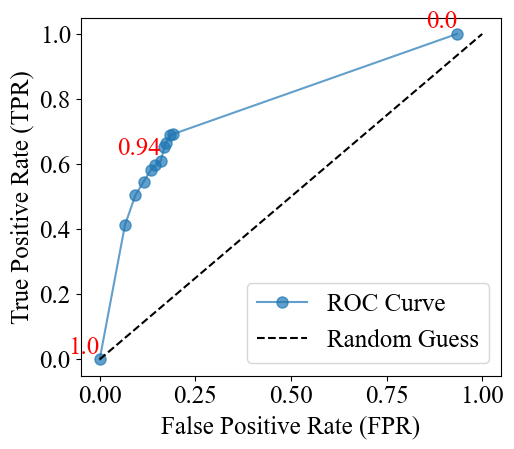

Confusion matrix for threshold 0.00:


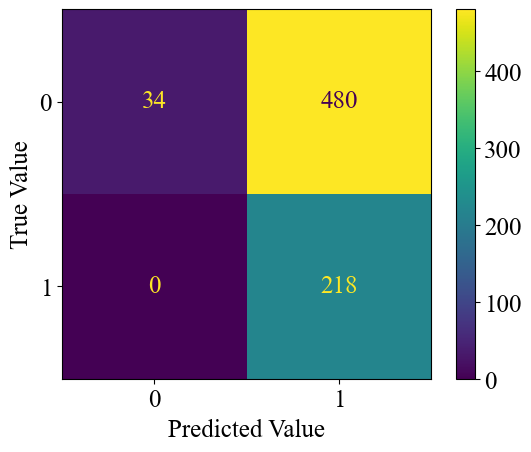

Confusion matrix for threshold 0.90:


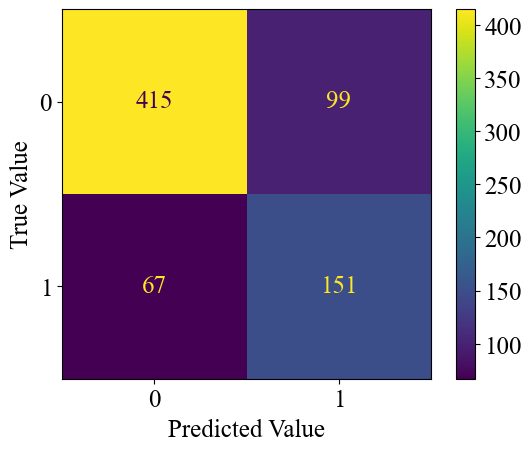

Confusion matrix for threshold 0.91:


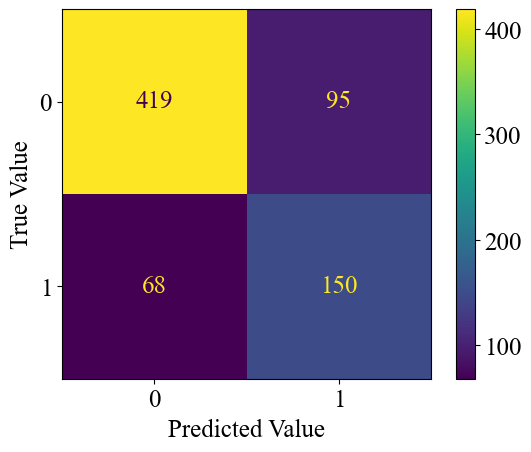

Confusion matrix for threshold 0.92:


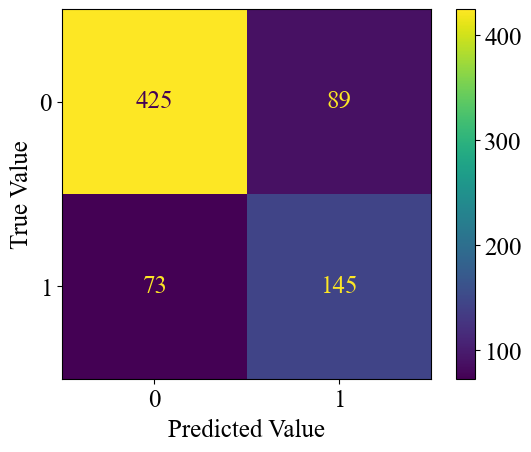

Confusion matrix for threshold 0.93:


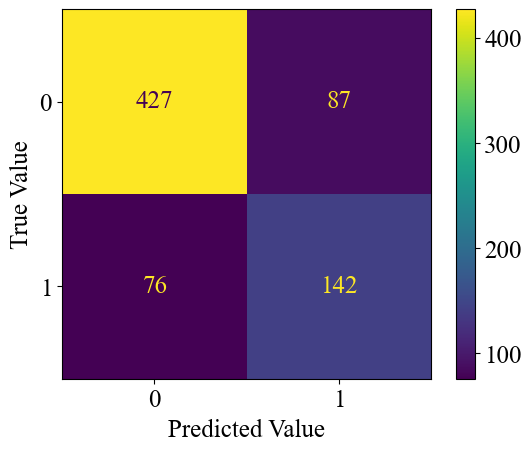

Confusion matrix for threshold 0.94:


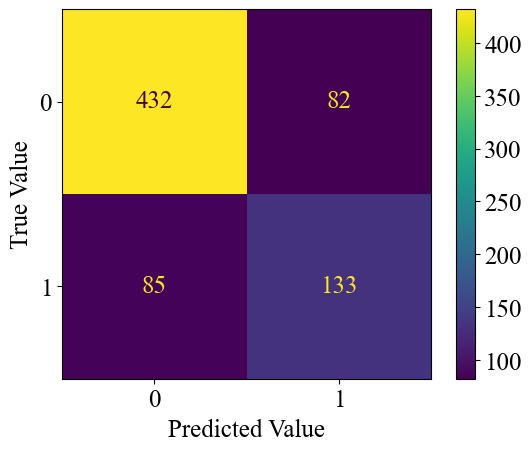

Confusion matrix for threshold 0.95:


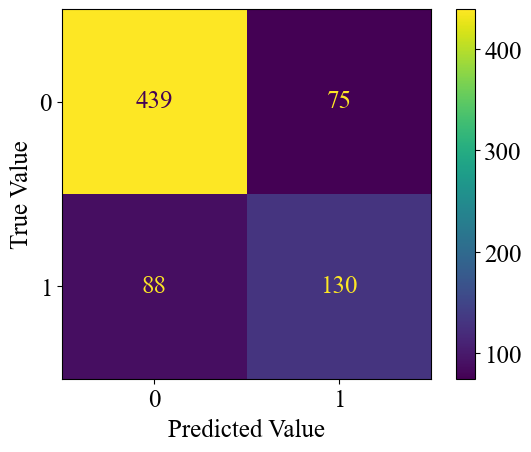

Confusion matrix for threshold 0.96:


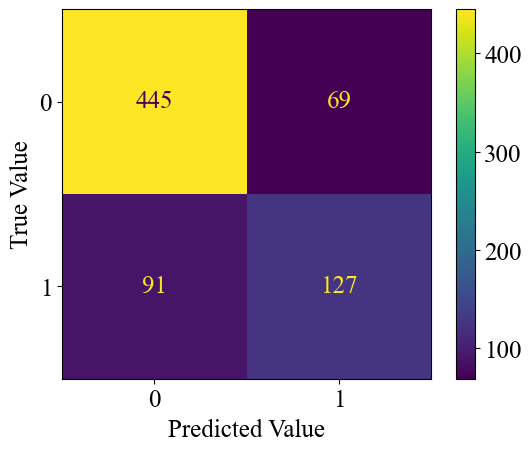

Confusion matrix for threshold 0.97:


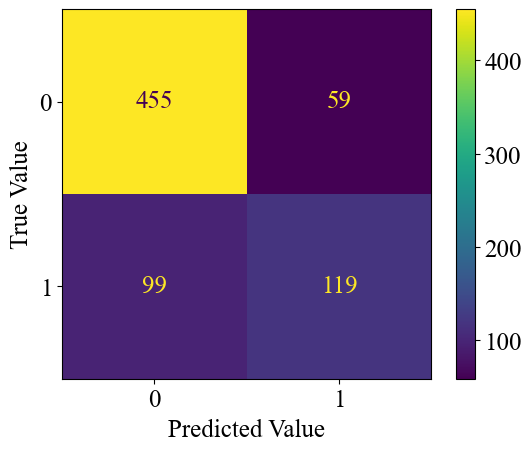

Confusion matrix for threshold 0.98:


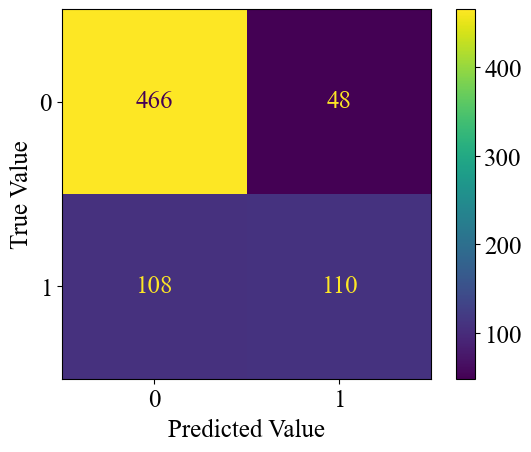

Confusion matrix for threshold 0.99:


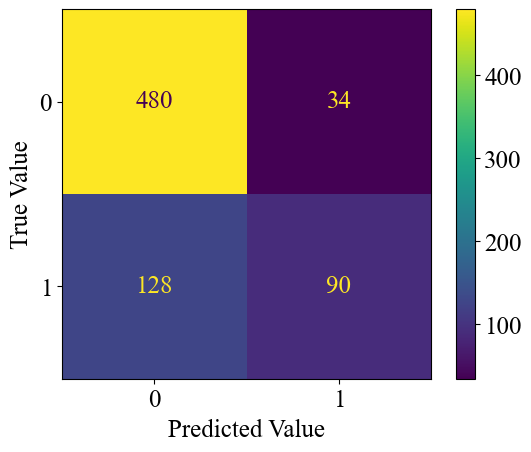

Confusion matrix for threshold 1.00:


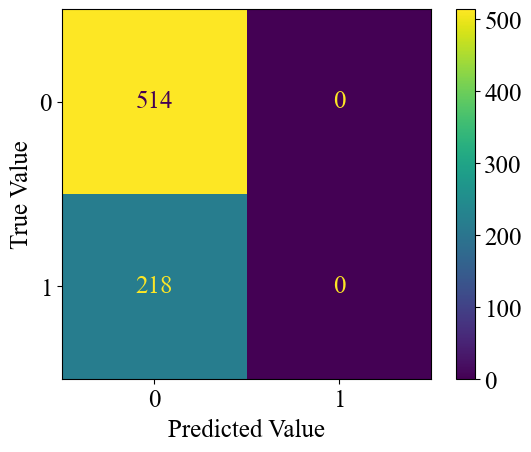

Test number: 9
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 206
Number of spoofed images: 494
Threshold: 0.00
Accuracy: 0.3455, Precision: 0.3187, Recall: 1.0000, F1-score: 0.4834

Threshold: 0.90
Accuracy: 0.7556, Precision: 0.5853, Recall: 0.6927, F1-score: 0.6345

Threshold: 0.91
Accuracy: 0.7542, Precision: 0.5837, Recall: 0.6881, F1-score: 0.6316

Threshold: 0.92
Accuracy: 0.7542, Precision: 0.5870, Recall: 0.6651, F1-score: 0.6237

Threshold: 0.93
Accuracy: 0.7556, Precision: 0.5917, Recall: 0.6514, F1-score: 0.6201

Threshold: 0.94
Accuracy: 0.7472, Precision: 0.5833, Recall: 0.6101, F1-score: 0.5964

Threshold: 0.95
Accuracy: 0.7500, Precision: 0.5909, Recall: 0.5963, F1-score: 0.5936

Threshold: 0.96
Accuracy: 0.7542, Precision: 0.6019, Recall: 0.5826, F1-score: 0.5921

Threshold: 0.97
Accuracy: 0.7626, Precision: 0.6296, Recall: 0.5459, F1-score: 0.5848

Threshold: 0.98
Accuracy: 0.7669, Precision: 0.6548, Recall: 0.5046, F1-score: 0

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


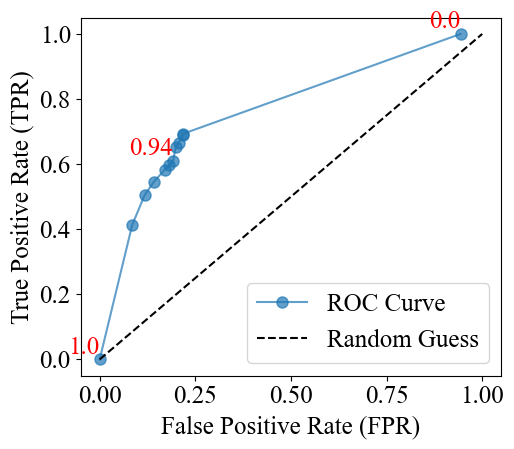

Confusion matrix for threshold 0.00:


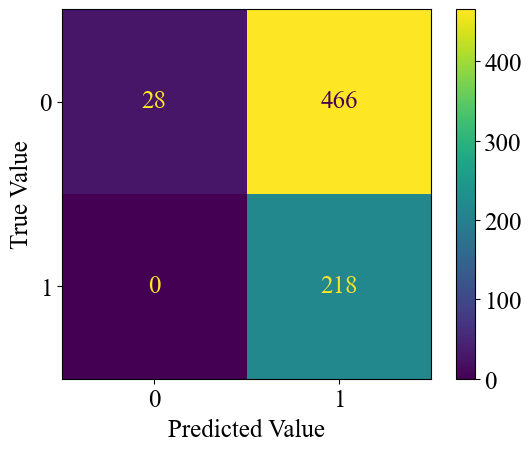

Confusion matrix for threshold 0.90:


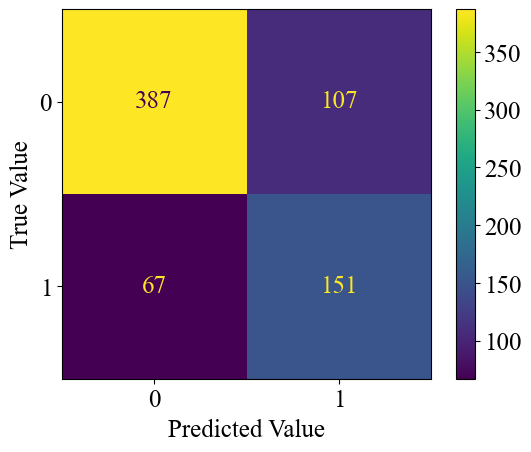

Confusion matrix for threshold 0.91:


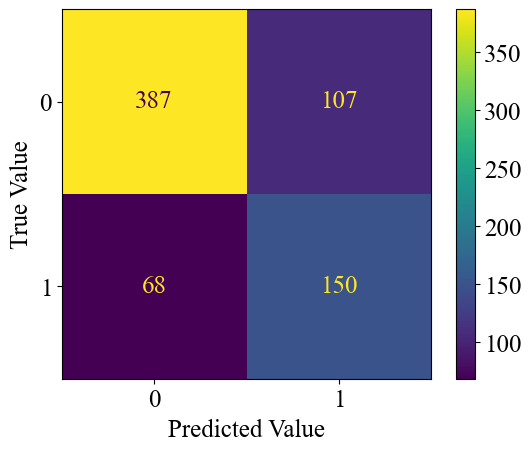

Confusion matrix for threshold 0.92:


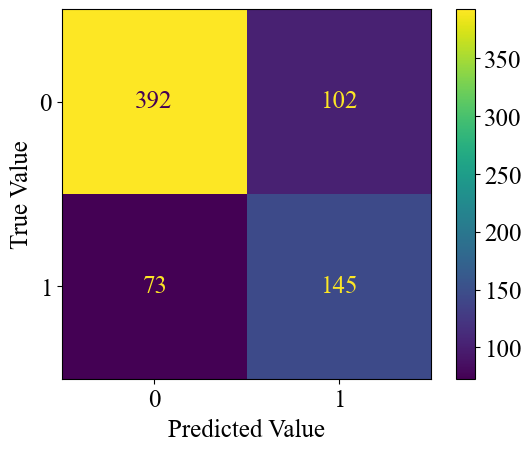

Confusion matrix for threshold 0.93:


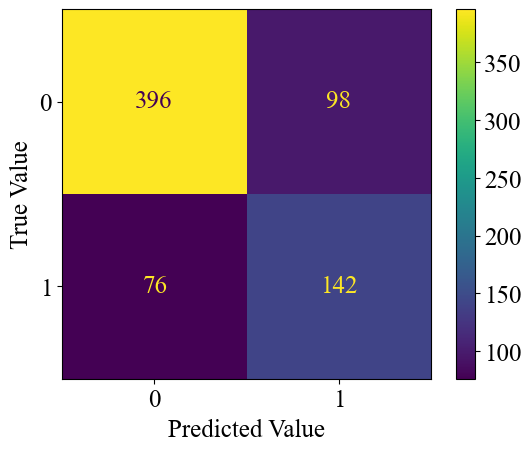

Confusion matrix for threshold 0.94:


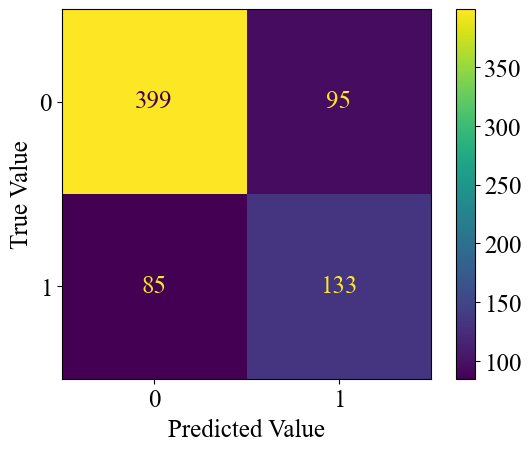

Confusion matrix for threshold 0.95:


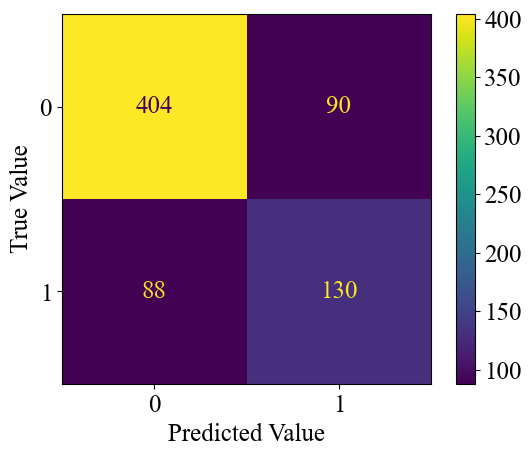

Confusion matrix for threshold 0.96:


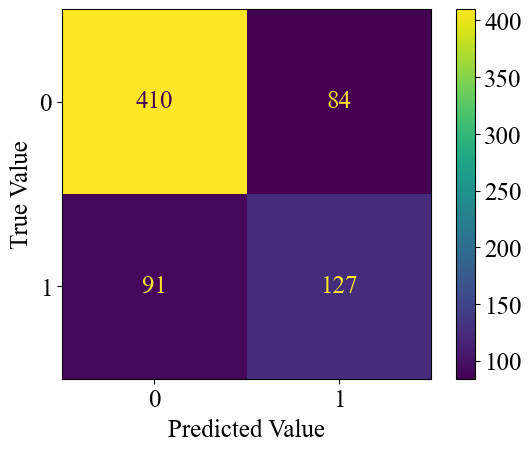

Confusion matrix for threshold 0.97:


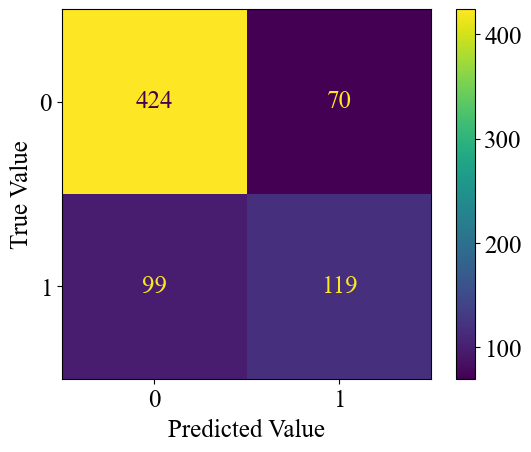

Confusion matrix for threshold 0.98:


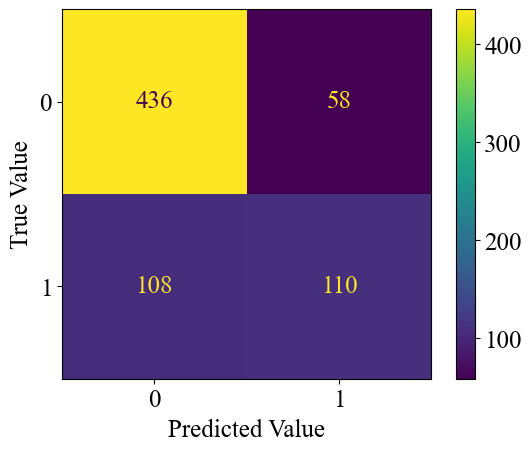

Confusion matrix for threshold 0.99:


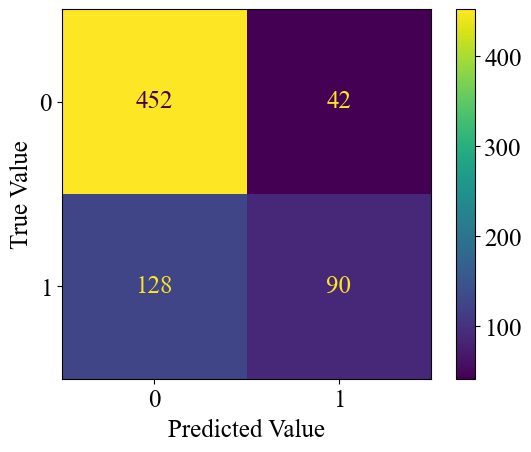

Confusion matrix for threshold 1.00:


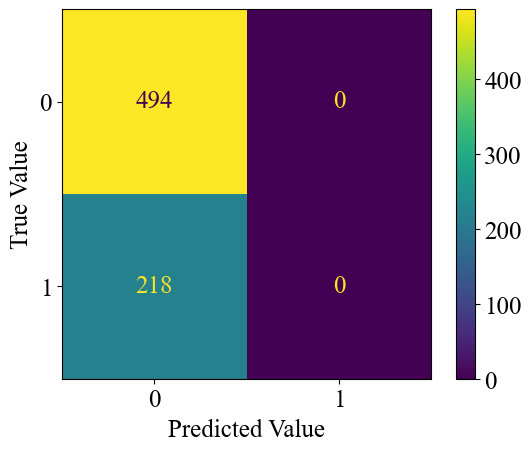

Test number: 10
Number of undetected images: 96
Number of real images: 218
Number of undetected images: 216
Number of spoofed images: 484
Threshold: 0.00
Accuracy: 0.3575, Precision: 0.3259, Recall: 1.0000, F1-score: 0.4915

Threshold: 0.90
Accuracy: 0.7664, Precision: 0.6089, Recall: 0.6927, F1-score: 0.6481

Threshold: 0.91
Accuracy: 0.7678, Precision: 0.6122, Recall: 0.6881, F1-score: 0.6479

Threshold: 0.92
Accuracy: 0.7650, Precision: 0.6118, Recall: 0.6651, F1-score: 0.6374

Threshold: 0.93
Accuracy: 0.7678, Precision: 0.6201, Recall: 0.6514, F1-score: 0.6353

Threshold: 0.94
Accuracy: 0.7564, Precision: 0.6073, Recall: 0.6101, F1-score: 0.6087

Threshold: 0.95
Accuracy: 0.7578, Precision: 0.6132, Recall: 0.5963, F1-score: 0.6047

Threshold: 0.96
Accuracy: 0.7607, Precision: 0.6225, Recall: 0.5826, F1-score: 0.6019

Threshold: 0.97
Accuracy: 0.7621, Precision: 0.6364, Recall: 0.5459, F1-score: 0.5877

Threshold: 0.98
Accuracy: 0.7664, Precision: 0.6627, Recall: 0.5046, F1-score: 

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


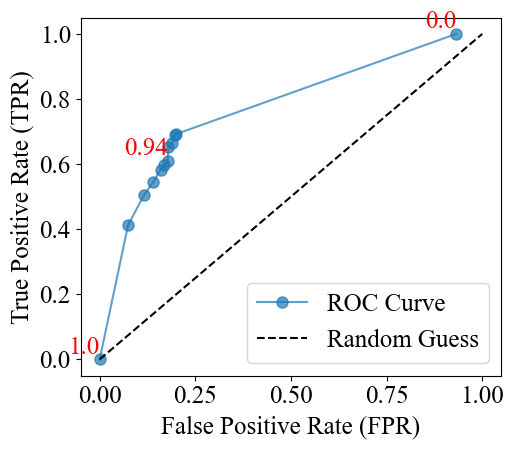

Confusion matrix for threshold 0.00:


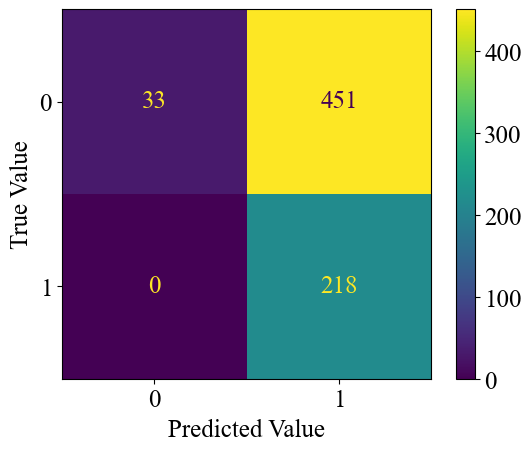

Confusion matrix for threshold 0.90:


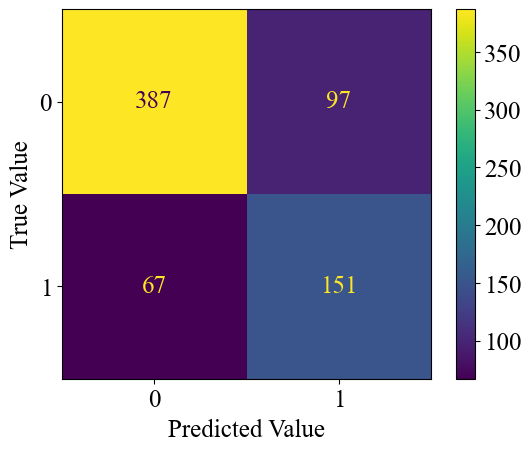

Confusion matrix for threshold 0.91:


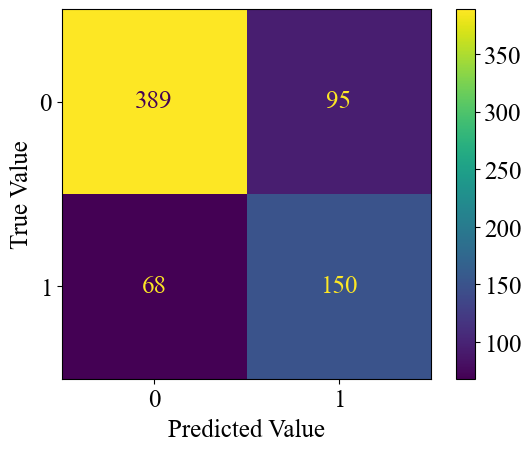

Confusion matrix for threshold 0.92:


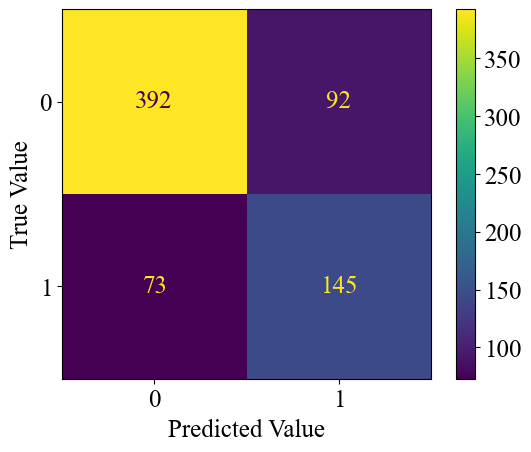

Confusion matrix for threshold 0.93:


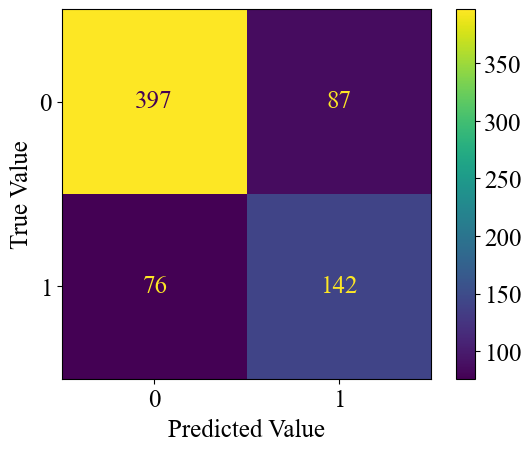

Confusion matrix for threshold 0.94:


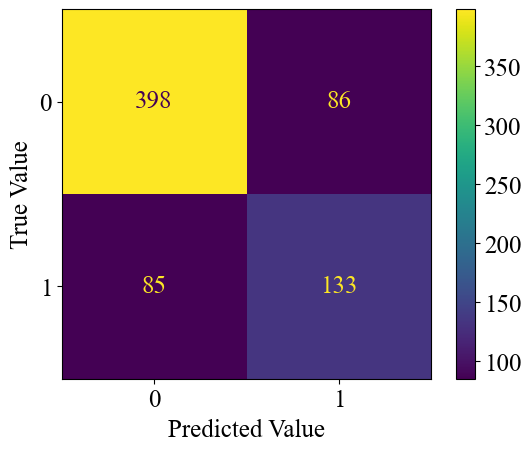

Confusion matrix for threshold 0.95:


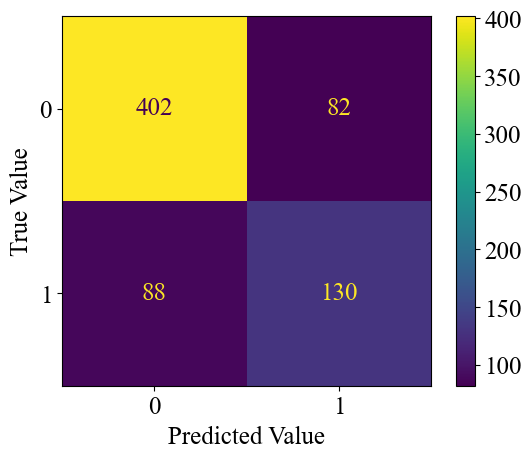

Confusion matrix for threshold 0.96:


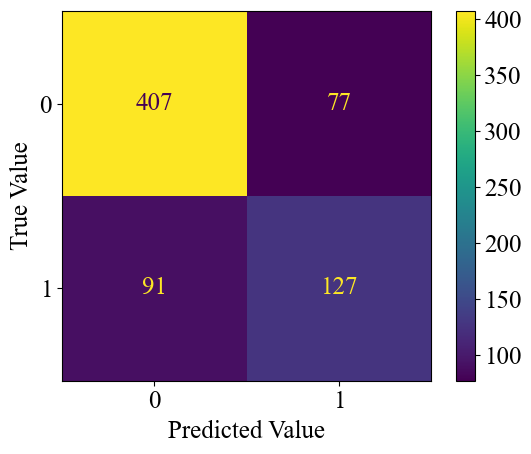

Confusion matrix for threshold 0.97:


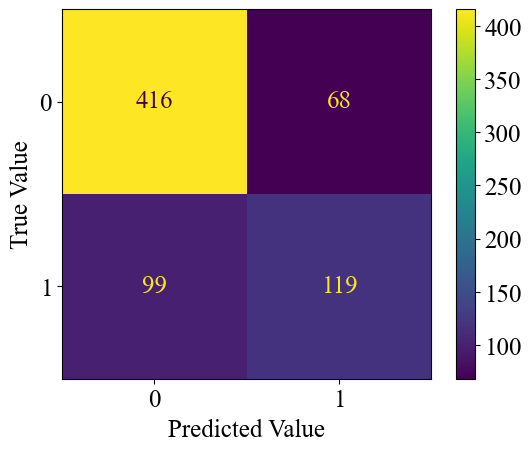

Confusion matrix for threshold 0.98:


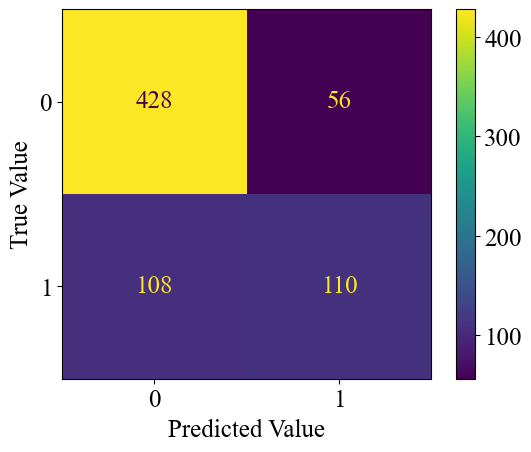

Confusion matrix for threshold 0.99:


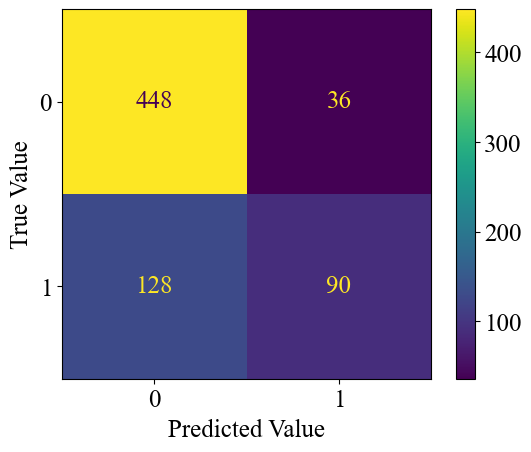

Confusion matrix for threshold 1.00:


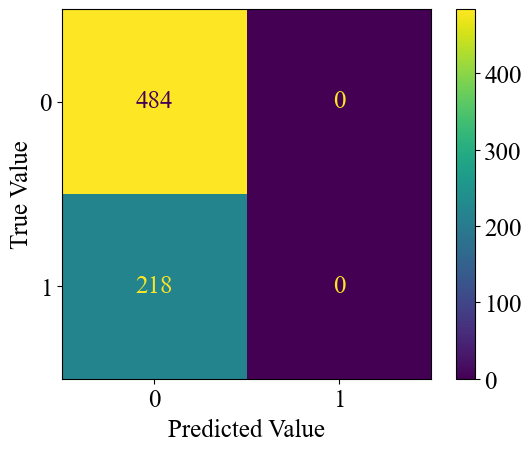

In [ ]:
from plotting import plot_conf_mat, plot_ROC, get_tpr_and_fpr

total_test_data = pd.DataFrame()

tpr_li_li = []
fpr_li_li = []

for test_n in np.arange(1, N_RUNS + 1):
    print(f"Test number: {test_n}")

    # Get a list of predictions and performance data for each threshold
    y_pred_li, y_true, test_data = run_test(DATASET_PATH_REAL, DATASET_PATH_ATTACK, SPOOF_THRESHOLDS, N_REAL, N_SPOOFED, test_n)
    total_test_data = pd.concat([total_test_data, test_data], ignore_index=True)

    # Visualize the results using ROC curve
    plot_ROC(y_true, y_pred_li, SPOOF_THRESHOLDS, test_n)

    # Get TPR and FPR for each test to later compute average ROC curve
    tpr_li = []
    fpr_li = []

    for y_pred in y_pred_li:
        tpr, fpr = get_tpr_and_fpr(y_true, y_pred)
        tpr_li.append(tpr)
        fpr_li.append(fpr)

    tpr_li_li.append(tpr_li)
    fpr_li_li.append(fpr_li)
    
    # Visualize the results for each threshold using confusion matrices
    for i, y_pred in enumerate(y_pred_li):
        print(f"Confusion matrix for threshold {SPOOF_THRESHOLDS[i]:.2f}:")
        plot_conf_mat(y_true, y_pred, SPOOF_THRESHOLDS[i], test_n)


#### Plotting the average ROC curve across all tests

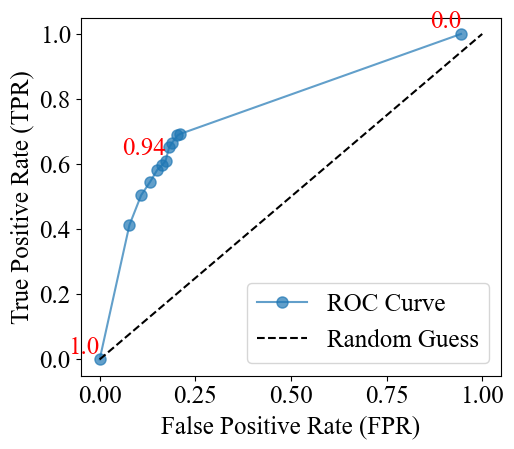

In [13]:
def get_average_rates(rate_li_li):
    rates_df = pd.DataFrame(rate_li_li)
    average_rates = list(rates_df.mean(axis=0))

    return average_rates

avg_tpr_li = get_average_rates(tpr_li_li)
avg_fpr_li = get_average_rates(fpr_li_li)

# Visualize the average ROC curve
plot_ROC(y_true, y_pred_li, SPOOF_THRESHOLDS, 'AVG', avg_rates=(avg_tpr_li, avg_fpr_li))


### 3. Analyze and save the results

In [14]:
# Get the average performance metrics for each threshold across all tests
total_test_data = total_test_data.drop(columns=["Test Number"])
average_metrics = total_test_data.groupby("Threshold").mean(numeric_only=True).reset_index()

# Inspect the average metrics
print("Average metrics across all tests:")
average_metrics

Average metrics across all tests:


Threshold  Accuracy  Precision    Recall  F1-score  \
0        0.00  0.342141   0.315772  1.000000  0.479951   
1        0.90  0.760374   0.589844  0.692661  0.637069   
2        0.91  0.763688   0.596161  0.688073  0.638771   
3        0.92  0.766725   0.605741  0.665138  0.633969   
4        0.93  0.767723   0.610311  0.651376  0.630085   
5        0.94  0.761709   0.607531  0.610092  0.608682   
6        0.95  0.764226   0.615784  0.596330  0.605767   
7        0.96  0.768404   0.628373  0.582569  0.604463   
8        0.97  0.770209   0.643845  0.545872  0.590687   
9        0.98  0.774084   0.670760  0.504587  0.575750   
10       0.99  0.767568   0.699200  0.412844  0.518983   
11       1.00  0.696410   0.000000  0.000000  0.000000   

    Undetected Real Images  Undetected Spoofed Images  
0                     96.0                      199.7  
1                     96.0                      199.7  
2                     96.0                      199.7  
3                     96.0                      199.7  
4                     96.0                      199.7  
5                     96.0                      199.7  
6                     96.0                      199.7  
7                     96.0                      199.7  
8                     96.0                      199.7  
9                     96.0                      199.7  
10                    96.0                      199.7  
11                    96.0                      199.7

In [15]:
# Save the results to CSV and Excel files
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

total_test_data.to_csv(f"{SAVE_PATH}test_results_FAS.csv", index=False)
total_test_data.to_excel(f"{SAVE_PATH}test_results_FAS.xlsx", index=False)

average_metrics.to_csv(f"{SAVE_PATH}average_metrics_FAS.csv", index=False)
average_metrics.to_excel(f"{SAVE_PATH}average_metrics_FAS.xlsx", index=False)